# Train Methods


In [1]:
import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
from model import Yolov1_1D
# from dataset import VOCDataset
from utils import (
    non_max_suppression,
    mean_average_precision,
    intersection_over_union,
    cellboxes_to_boxes,
    get_bboxes,
    plot_image,
    save_checkpoint,
    load_checkpoint,
)
from loss import Yolo1DLoss
import pandas as pd



seed = 123
torch.manual_seed(seed)

# Hyperparameters etc. 
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 16 # 64 in original paper 
WEIGHT_DECAY = 0
EPOCHS = 1000
NUM_WORKERS = 3
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "overfit_test_train.pth.tar"
# IMG_DIR = "data/images"
# LABEL_DIR = "data/labels"

ohcl_segments_df = pd.read_csv("Datasets/ohcl_segments_df.csv")
label_df = pd.read_csv("Datasets/lable_df.csv")

In [2]:
def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")
    
    return sum(mean_loss)/len(mean_loss)

In [3]:
#  get all the unique instances from the label_df
instances = label_df["Instance"].unique()
instances

array([   0,    1,    2, ..., 1692, 1693, 1694], dtype=int64)

In [4]:
#  get random 80% of the instances as training instances and the rest as testing instances
train_instances = np.random.choice(instances, size=int(0.8 * len(instances)), replace=False)
test_instances = [instance for instance in instances if instance not in train_instances]

In [5]:
train_instances.sort()
train_instances

array([   0,    3,    4, ..., 1692, 1693, 1694], dtype=int64)

In [6]:
# get  the length of the train_instances and test_instances
len(train_instances), len(test_instances)

(1356, 339)

In [7]:
from dataset import OHCLDataset  # Assuming your code is saved in dataset.py

# Load the DataFrame (normally imported as shown)
label_df = pd.read_csv('Datasets/lable_df.csv')

ohcl_segments_df = pd.read_csv('Datasets/ohcl_segments_df.csv')



label_df_train = label_df.copy()
label_df_test = label_df.copy()
# drop the rows that are not in the training instances
label_df_train= label_df_train[label_df_train["Instance"].isin(train_instances)]
label_df_test = label_df_test[label_df_test["Instance"].isin(test_instances)]

ohcl_segments_df_train = ohcl_segments_df.copy()
ohcl_segments_df_test = ohcl_segments_df.copy()
# drop the rows that are not in the training instances
ohcl_segments_df_train = ohcl_segments_df_train[ohcl_segments_df_train["Instance"].isin(train_instances)]
ohcl_segments_df_test = ohcl_segments_df_test[ohcl_segments_df_test["Instance"].isin(test_instances)]

new_instances = 0

dataframes = [label_df_train, label_df_test, ohcl_segments_df_train, ohcl_segments_df_test]

for i, df in enumerate(dataframes):
    # Make sure the new_instances counter resets for each DataFrame
    new_instances = 0
    
    # Get the instance value of the first row
    init_instances = df.iloc[0]["Instance"]
    
    # Loop through the DataFrame by index to update the 'Instance' column
    for index in df.index:
        row_instance = df.at[index, "Instance"]
        if row_instance != init_instances:
            init_instances = row_instance
            new_instances += 1
        df.at[index, "Instance"] = new_instances
    
    # Reset index of the DataFrame
    df.reset_index(drop=True, inplace=True)

    # Reassign the modified DataFrame back to the correct variable
    if i == 0:
        label_df_train = df
    elif i == 1:
        label_df_test = df
    elif i == 2:
        ohcl_segments_df_train = df
    elif i == 3:
        ohcl_segments_df_test = df







# Convert "Instance" and "Pattern_Id" columns into a MultiIndex
label_df_train = label_df_train.set_index(['Instance', 'Pattern_Id'])


# Convert "Instance" and "Time" columns into a MultiIndex
ohcl_segments_df_train = ohcl_segments_df_train.set_index(['Instance', 'Time'])

ohcl_segments_df = ohcl_segments_df.set_index(['Instance', 'Time'])
label_df = label_df.set_index(['Instance', 'Pattern_Id'])




# Initialize the OHCLDataset class
train_dataset = OHCLDataset(label_df=label_df_train, ohcl_segments_df=ohcl_segments_df_train)

In [8]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.min_rows', 10)


In [9]:
ohcl_segments_df

Open      High       Low     Close
Instance Time                                        
0        0     0.889953  0.929758  0.881865  0.929758
         1     0.895487  0.928977  0.860721  0.896694
         2     0.901022  0.928197  0.839577  0.863630
         3     0.906556  0.927416  0.818433  0.830566
         4     0.821626  0.843338  0.792039  0.801618
...                 ...       ...       ...       ...
1694     219   0.458294  0.494318  0.449315  0.494318
         220   0.466946  0.500882  0.460770  0.499686
         221   0.475597  0.507445  0.472226  0.505054
         222   0.484249  0.514009  0.483681  0.510422
         223   0.501378  0.520985  0.480785  0.505343

[379680 rows x 4 columns]

In [10]:
ohcl_segments_df_train

Open      High       Low     Close
Instance Time                                        
0        0     0.889953  0.929758  0.881865  0.929758
         1     0.895487  0.928977  0.860721  0.896694
         2     0.901022  0.928197  0.839577  0.863630
         3     0.906556  0.927416  0.818433  0.830566
         4     0.821626  0.843338  0.792039  0.801618
...                 ...       ...       ...       ...
1355     219   0.458294  0.494318  0.449315  0.494318
         220   0.466946  0.500882  0.460770  0.499686
         221   0.475597  0.507445  0.472226  0.505054
         222   0.484249  0.514009  0.483681  0.510422
         223   0.501378  0.520985  0.480785  0.505343

[303744 rows x 4 columns]

In [11]:
label_df_train

Pattern    Center     Width
Instance Pattern_Id                             
0        0                 4  0.977679  0.035714
         1                 5  0.520089  0.174107
         2                 1  0.319196  0.084821
1        0                 6  0.136161  0.191964
2        0                 1  0.533482  0.120536
...                      ...       ...       ...
1353     0                 4  0.446429  0.026786
         1                 0  0.296875  0.031250
1354     0                 4  0.866071  0.035714
1355     0                 0  0.142857  0.035714
         1                 5  0.593750  0.053571

[2180 rows x 3 columns]

In [12]:
label_df

Pattern    Center     Width
Instance Pattern_Id                             
0        0                 4  0.977679  0.035714
         1                 5  0.520089  0.174107
         2                 1  0.319196  0.084821
1        0                 6  0.138393  0.276786
         1                 6  0.906250  0.187500
...                      ...       ...       ...
1692     0                 4  0.446429  0.026786
         1                 0  0.296875  0.031250
1693     0                 4  0.866071  0.035714
1694     0                 0  0.142857  0.035714
         1                 5  0.593750  0.053571

[2753 rows x 3 columns]

In [13]:
# get the number of each pattern in label_df , sort them by th pattern
label_df["Pattern"].value_counts().sort_index()



Pattern
0    448
1    501
2    272
3    342
4    625
5    309
6    196
7     60
Name: count, dtype: int64

In [14]:
label_df_train["Pattern"].value_counts().sort_index()

Pattern
0    355
1    392
2    215
3    281
4    492
5    244
6    152
7     49
Name: count, dtype: int64

In [15]:
label_df_test["Pattern"].value_counts().sort_index()

Pattern
0     93
1    109
2     57
3     61
4    133
5     65
6     44
7     11
Name: count, dtype: int64

In [16]:
label_df_train.loc[0].copy()

Pattern    Center     Width
Pattern_Id                             
0                 4  0.977679  0.035714
1                 5  0.520089  0.174107
2                 1  0.319196  0.084821

In [17]:
label_df.loc[0].copy()

Pattern    Center     Width
Pattern_Id                             
0                 4  0.977679  0.035714
1                 5  0.520089  0.174107
2                 1  0.319196  0.084821

In [18]:
train_dataset[0]

Index :  0
label_df :                       Pattern    Center     Width
Instance Pattern_Id                             
0        0                 4  0.977679  0.035714
         1                 5  0.520089  0.174107
         2                 1  0.319196  0.084821
1        0                 6  0.136161  0.191964
2        0                 1  0.533482  0.120536
...                      ...       ...       ...
1353     0                 4  0.446429  0.026786
         1                 0  0.296875  0.031250
1354     0                 4  0.866071  0.035714
1355     0                 0  0.142857  0.035714
         1                 5  0.593750  0.053571

[2180 rows x 3 columns]
label_row :              Pattern    Center     Width
Pattern_Id                             
0                 4  0.977679  0.035714
1                 5  0.520089  0.174107
2                 1  0.319196  0.084821
ohcl_row :            Open      High       Low     Close
Time                                        


(tensor([[0.8900, 0.8955, 0.9010, 0.9066, 0.8216, 0.8110, 0.9249, 0.8661, 0.8652,
          0.8643, 0.8633, 0.8274, 0.8078, 0.8757, 0.9023, 0.8905, 0.8787, 0.8670,
          0.9774, 0.9361, 0.8414, 0.7733, 0.7683, 0.7634, 0.7584, 0.7235, 0.7590,
          0.7478, 0.7605, 0.7617, 0.7629, 0.7640, 0.7652, 0.7769, 0.7733, 0.7765,
          0.7882, 0.7999, 0.8116, 0.8233, 0.8167, 0.7816, 0.8744, 0.8413, 0.8081,
          0.7750, 0.7854, 0.8929, 0.9553, 0.8995, 0.9056, 0.9117, 0.9177, 0.9238,
          0.9149, 0.8578, 0.8561, 0.8738, 0.8916, 0.9093, 0.9151, 0.8668, 0.9300,
          0.9040, 0.8951, 0.8863, 0.8774, 0.8159, 0.8521, 0.9234, 0.8491, 0.8460,
          0.8428, 0.8397, 0.8133, 0.8591, 0.9023, 0.8199, 0.8304, 0.8408, 0.8512,
          0.8740, 0.8289, 0.7563, 0.7233, 0.7198, 0.7163, 0.7128, 0.7092, 0.6405,
          0.6132, 0.5998, 0.6099, 0.6200, 0.6301, 0.6060, 0.5385, 0.4900, 0.6228,
          0.6286, 0.6343, 0.6401, 0.6445, 0.5719, 0.5956, 0.5515, 0.5257, 0.4999,
          0.4740

In [19]:
train_dataset = OHCLDataset(label_df=label_df, ohcl_segments_df=ohcl_segments_df)

for i in range(len(train_dataset)):
    ohcl, label = train_dataset[i]
    # print(f"Instance {i}:")
    # print("length of OHCL Data:", len(ohcl[0]))
    # print("OHCL Data (reshaped):", ohcl)
    # print("Label Data:", label)
    print("Shape of OHCL data : ", ohcl.shape)
    print("Shape of Label data : ", label.shape)


Index :  0
label_df :                       Pattern    Center     Width
Instance Pattern_Id                             
0        0                 4  0.977679  0.035714
         1                 5  0.520089  0.174107
         2                 1  0.319196  0.084821
1        0                 6  0.138393  0.276786
         1                 6  0.906250  0.187500
...                      ...       ...       ...
1692     0                 4  0.446429  0.026786
         1                 0  0.296875  0.031250
1693     0                 4  0.866071  0.035714
1694     0                 0  0.142857  0.035714
         1                 5  0.593750  0.053571

[2753 rows x 3 columns]
label_row :              Pattern    Center     Width
Pattern_Id                             
0                 4  0.977679  0.035714
1                 5  0.520089  0.174107
2                 1  0.319196  0.084821
ohcl_row :            Open      High       Low     Close
Time                                        


In [20]:

from dataset import OHCLDataset  # Assuming your code is saved in dataset.py
from IPython.display import clear_output

# Load the DataFrame (normally imported as shown)
label_df = pd.read_csv('Datasets/lable_df.csv')

ohcl_segments_df = pd.read_csv('Datasets/ohcl_segments_df.csv')



label_df_train = label_df.copy()
label_df_test = label_df.copy()
# drop the rows that are not in the training instances
label_df_train= label_df_train[label_df_train["Instance"].isin(train_instances)]
label_df_test = label_df_test[label_df_test["Instance"].isin(test_instances)]

ohcl_segments_df_train = ohcl_segments_df.copy()
ohcl_segments_df_test = ohcl_segments_df.copy()
# drop the rows that are not in the training instances
ohcl_segments_df_train = ohcl_segments_df_train[ohcl_segments_df_train["Instance"].isin(train_instances)]
ohcl_segments_df_test = ohcl_segments_df_test[ohcl_segments_df_test["Instance"].isin(test_instances)]

new_instances = 0

dataframes = [label_df_train, label_df_test, ohcl_segments_df_train, ohcl_segments_df_test]

for i, df in enumerate(dataframes):
    # Make sure the new_instances counter resets for each DataFrame
    new_instances = 0
    
    # Get the instance value of the first row
    init_instances = df.iloc[0]["Instance"]
    
    # Loop through the DataFrame by index to update the 'Instance' column
    for index in df.index:
        row_instance = df.at[index, "Instance"]
        if row_instance != init_instances:
            init_instances = row_instance
            new_instances += 1
        df.at[index, "Instance"] = new_instances
    
    # Reset index of the DataFrame
    df.reset_index(drop=True, inplace=True)

    # Reassign the modified DataFrame back to the correct variable
    if i == 0:
        label_df_train = df
    elif i == 1:
        label_df_test = df
    elif i == 2:
        ohcl_segments_df_train = df
    elif i == 3:
        ohcl_segments_df_test = df

# Convert "Instance" and "Pattern_Id" columns into a MultiIndex
label_df_train = label_df_train.set_index(['Instance', 'Pattern_Id'])
label_df_test = label_df_test.set_index(['Instance', 'Pattern_Id'])


# Convert "Instance" and "Time" columns into a MultiIndex
ohcl_segments_df_train = ohcl_segments_df_train.set_index(['Instance', 'Time'])
ohcl_segments_df_test = ohcl_segments_df_test.set_index(['Instance', 'Time'])

label_df_all = label_df.set_index(['Instance', 'Pattern_Id'])
ohcl_segments_df_all = ohcl_segments_df.set_index(['Instance', 'Time'])

# Initialize the OHCLDataset class
train_dataset = OHCLDataset(label_df=label_df_train, ohcl_segments_df=ohcl_segments_df_train)
test_dataset = OHCLDataset(label_df=label_df_test, ohcl_segments_df=ohcl_segments_df_test)
all_dataset = OHCLDataset(label_df=label_df_all, ohcl_segments_df=ohcl_segments_df_all)



model = Yolov1_1D(in_channels = 4,split_size=7, num_boxes=2, num_classes=8).to(DEVICE)
optimizer = optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
loss_fn = Yolo1DLoss()

# if LOAD_MODEL:
#     load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

# train_dataset = VOCDataset(
#     "data/8examples.csv",
#     transform=transform,
#     img_dir=IMG_DIR,
#     label_dir=LABEL_DIR,
# )

# test_dataset = VOCDataset(
#     "data/test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
# )

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    drop_last=False,
)

mAP_history = []
test_mAP_history = []
mean_loss_history = []

for epoch in tqdm(range(EPOCHS), desc="Training Epochs"):
    clear_output(wait=True)  # Clear the output of the cell before printing new lines
    
    
    # for x, y in train_loader:
    #    x = x.to(DEVICE)
    #    for idx in range(8):
    #        bboxes = cellboxes_to_boxes(model(x))
    #        bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
    #        plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

    #    import sys
    #    sys.exit()

    pred_boxes, target_boxes = get_bboxes(
        train_loader, model, iou_threshold=0.5, threshold=0.4
    )
    
    # print("pred_boxes in train.py", pred_boxes)
    # print ("target_boxes in train.py", target_boxes)

    mean_avg_prec = mean_average_precision(
        pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
    )
    print(f"Train mAP: {mean_avg_prec}")
    mAP_history.append(mean_avg_prec)
    
    test_pred_boxes, test_target_boxes = get_bboxes(
        test_loader, model, iou_threshold=0.5, threshold=0.4
    )
    
    test_mean_avg_prec = mean_average_precision(
        test_pred_boxes, test_target_boxes, iou_threshold=0.5, box_format="midpoint"
    )
    print(f"Test mAP: {test_mean_avg_prec}")
    test_mAP_history.append(test_mean_avg_prec)

    if mean_avg_prec > 0.9:
       checkpoint = {
           "state_dict": model.state_dict(),
           "optimizer": optimizer.state_dict(),
       }
       save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
       import time
       time.sleep(10)
    print("Epoch:", epoch)
    mean_loss = train_fn(train_loader, model, optimizer, loss_fn)
    mean_loss_history.append(mean_loss)
    print("Epoch:", epoch)

Train mAP: 0.8414974808692932


In [ ]:

pred_boxes, target_boxes = get_bboxes(
    train_loader, model, iou_threshold=0.5, threshold=0.4
)

# print("pred_boxes in train.py", pred_boxes)
# print ("target_boxes in train.py", target_boxes)

mean_avg_prec = mean_average_precision(
    pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
)
print(f"Train mAP: {mean_avg_prec}")
mAP_history.append(mean_avg_prec)

test_pred_boxes, test_target_boxes = get_bboxes(
    test_loader, model, iou_threshold=0.5, threshold=0.4
)

test_mean_avg_prec = mean_average_precision(
    test_pred_boxes, test_target_boxes, iou_threshold=0.5, box_format="midpoint"
)
print(f"Test mAP: {test_mean_avg_prec}")
test_mAP_history.append(test_mean_avg_prec)

Train mAP: 0.9869256019592285
Test mAP: 0.004586527124047279


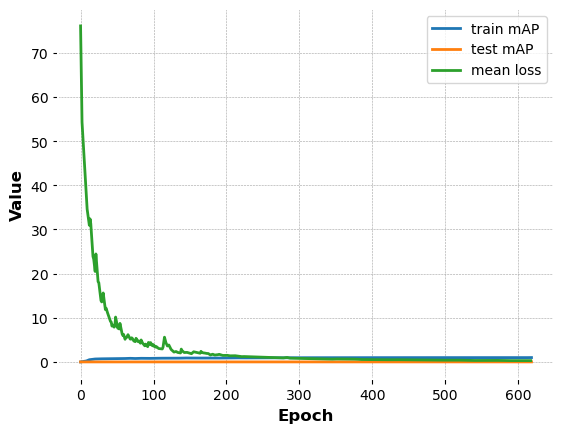

In [ ]:
#  plot a line graph of the mAP history
import matplotlib.pyplot as plt

plt.plot(mAP_history, label="train mAP")
plt.plot(test_mAP_history, label="test mAP")
plt.plot(mean_loss_history, label="mean loss")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.show()


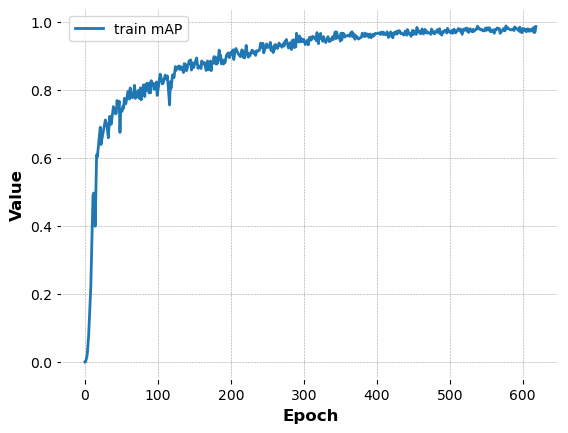

In [ ]:
#  plot a line graph of the mAP history
import matplotlib.pyplot as plt

plt.plot(mAP_history, label="train mAP")
# plt.plot(test_mAP_history, label="test mAP")
# plt.plot(mean_loss_history, label="mean loss")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.show()


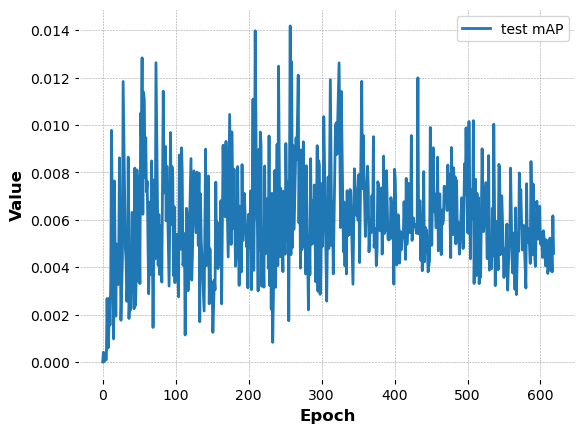

In [ ]:
#  plot a line graph of the mAP history
import matplotlib.pyplot as plt

# plt.plot(mAP_history, label="train mAP")
plt.plot(test_mAP_history, label="test mAP")
# plt.plot(mean_loss_history, label="mean loss")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.show()


In [ ]:
checkpoint = {
    "state_dict": model.state_dict(),
    "optimizer": optimizer.state_dict(),
}
save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
import time
time.sleep(10)

=> Saving checkpoint


In [ ]:
def load_checkpoint(checkpoint_file, model, optimizer=None):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file)  # Load the checkpoint file
    model.load_state_dict(checkpoint["state_dict"])  # Load model weights
    if optimizer:
        optimizer.load_state_dict(checkpoint["optimizer"])  # Load optimizer state (if provided)


loaded_model = load_checkpoint(LOAD_MODEL_FILE, model, optimizer)


=> Loading checkpoint


In [ ]:
#  load one item from test_loader
data = next(iter(train_loader))
data

[tensor([[[0.2266, 0.1338, 0.0410,  ..., 0.6598, 0.7961, 0.7765],
          [0.3037, 0.2316, 0.1594,  ..., 0.7524, 0.8255, 0.8272],
          [0.2114, 0.1253, 0.0392,  ..., 0.6082, 0.7738, 0.7605],
          [0.2750, 0.1980, 0.1211,  ..., 0.7498, 0.7809, 0.8246]],
 
         [[0.2869, 0.2650, 0.3950,  ..., 0.4816, 0.4531, 0.4245],
          [0.3674, 0.4280, 0.4664,  ..., 0.5731, 0.5143, 0.4555],
          [0.2552, 0.2215, 0.3572,  ..., 0.4672, 0.4176, 0.3680],
          [0.2841, 0.4088, 0.4648,  ..., 0.5478, 0.4757, 0.4037]],
 
         [[0.9562, 0.9429, 0.7209,  ..., 0.3528, 0.5598, 0.3779],
          [0.9579, 0.9438, 0.7349,  ..., 0.5467, 0.5598, 0.3858],
          [0.7690, 0.7287, 0.6035,  ..., 0.3528, 0.4636, 0.3142],
          [0.7842, 0.7487, 0.6575,  ..., 0.5233, 0.5048, 0.3437]],
 
         ...,
 
         [[0.5542, 0.5166, 0.4623,  ..., 0.5915, 0.4071, 0.2227],
          [0.5861, 0.5360, 0.5689,  ..., 0.6251, 0.4317, 0.2383],
          [0.5026, 0.4623, 0.4527,  ..., 0.5653, 0.

In [ ]:
from matplotlib import pyplot as plt
import mplfinance as mpf

pattern_encoding = {'Double Top, Adam and Adam': 0, 'Triangle, symmetrical': 1, 'Double Bottom, Eve and Adam': 2, 'Head-and-shoulders top': 3, 'Double Bottom, Adam and Adam': 4, 'Head-and-shoulders bottom': 5, 'Flag, high and tight': 6, 'Cup with handle': 7}
# Assuming pattern_encoding dictionary is available
pattern_encoding_inv = pattern_encoding
pattern_encoding_inv = {v: k for k, v in pattern_encoding_inv.items()}
# Colors for the patterns
colors = ['red', 'green', 'blue', 'orange', 'purple', 'yellow', 'black', 'pink']


def plot_image(ohcl_data, boxes ):
    
    # Transpose the tensor to make it [224, 4] and move to CPU
    tensor_transposed = ohcl_data.T.cpu()

    # Convert to a pandas DataFrame
    ohcl_data = pd.DataFrame(tensor_transposed.numpy(), columns=['Open', 'High', 'Low', 'Close'])
    
    # Create a candlestick plot using mplfinance
    ohlc_for_mpf = ohcl_data[['Open', 'High', 'Low', 'Close']].copy()
    ohlc_for_mpf.index = pd.to_datetime(ohcl_data.index)
    
    # Create the base plot (this returns a figure and axes)
    fig, axes = mpf.plot(ohlc_for_mpf, type='candle', style='charles', title=f'OHLC Chart with Patterns',
                         ylabel='Price', figsize=(12, 6), returnfig=True)  # Set figsize here
    
    ax = axes[0]  # Access the first (and only) axis object
    
    # Patterns data for the current instance
    # patters = boxes
    
    # Loop through the patterns and highlight them on the chart
    color_index = 0
    # for index, row in patters.iterrows():
    for box in boxes:   
        pattern_center = box[2]
        pattern_width = box[3]
        pattern_label = pattern_encoding_inv[box[0]]
        
        # Calculate pattern start and end positions (scaled for the width)
        pattern_start = (pattern_center - pattern_width/2) * len(ohlc_for_mpf)
        pattern_end = (pattern_center + pattern_width/2) * len(ohlc_for_mpf)
        
        # Add a vertical span (highlight the pattern) to the chart
        ax.axvspan(pattern_start, pattern_end, color=colors[color_index], alpha=0.2, label=pattern_label)
        color_index += 1

    # Customize the chart with grid, labels, and legend
    ax.grid(True)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Patterns")
    
    # Show the chart
    plt.show()

 predicted patterns


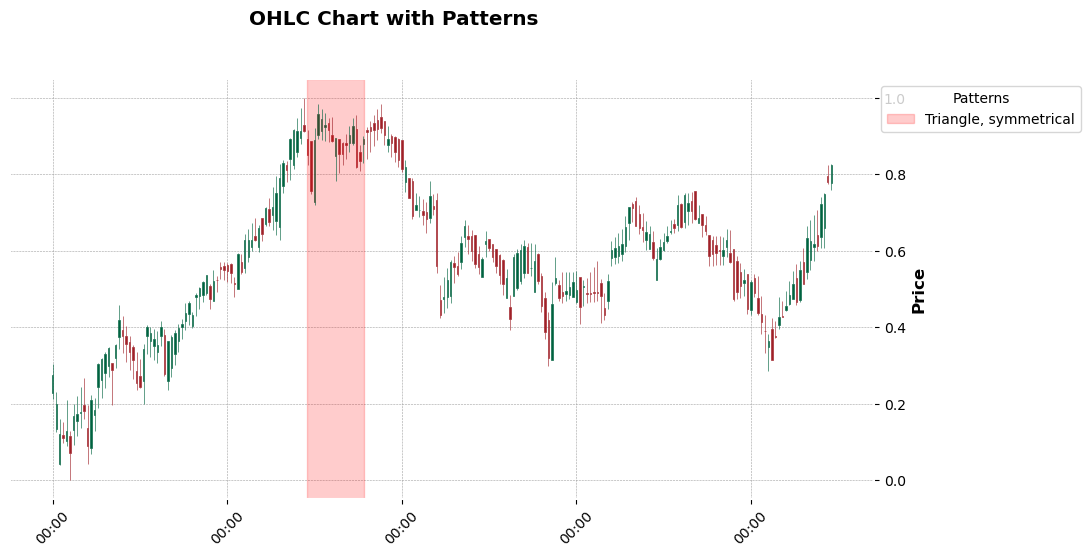

[[1.0, 1.0530540943145752, 0.36110466718673706, 0.07269991934299469]]
Real Patterns


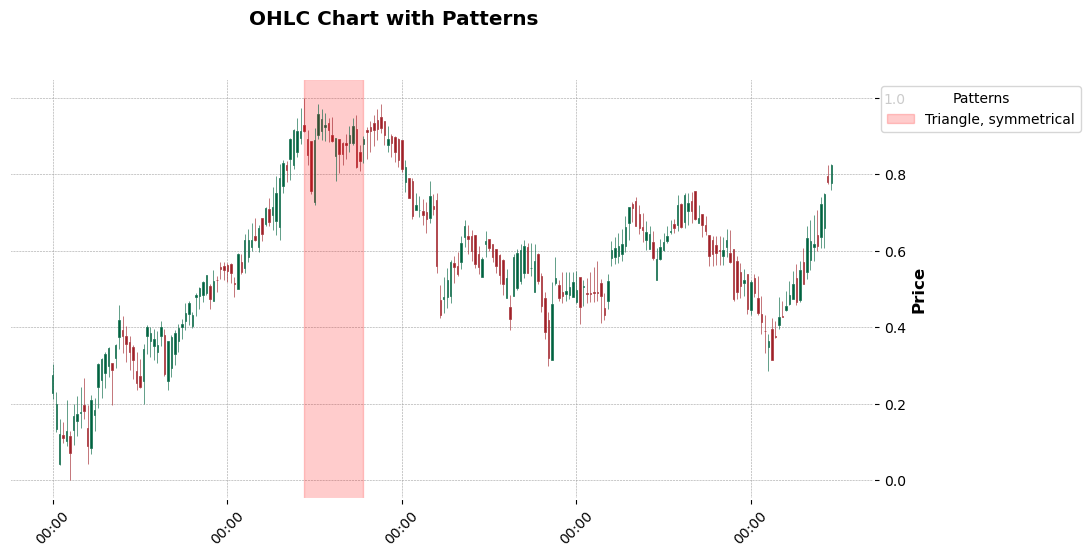

[[1.0, 1.0530540943145752, 0.36110466718673706, 0.07269991934299469]]
 predicted patterns


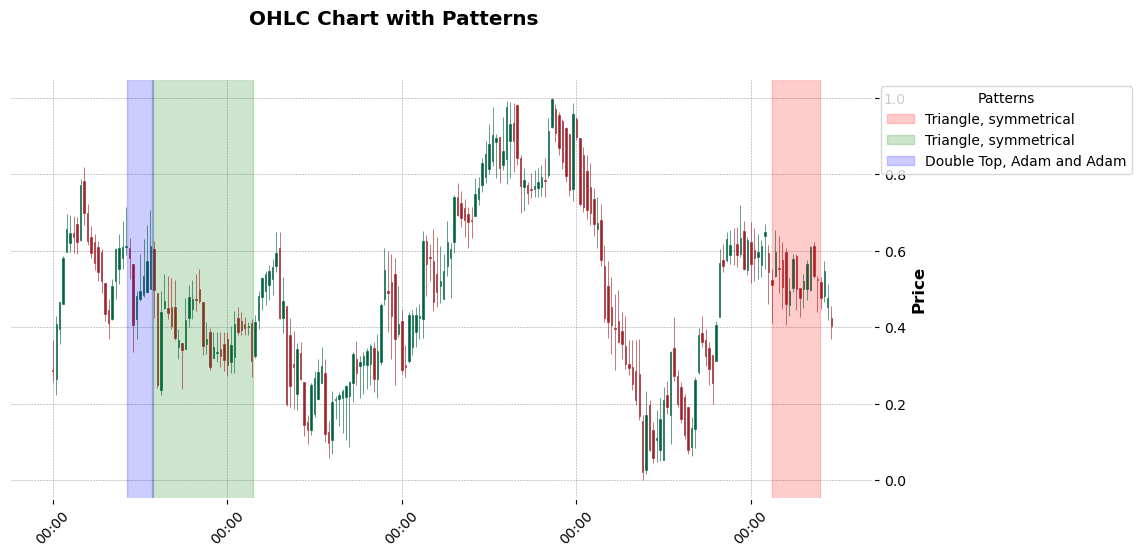

[[1.0, 1.0143786668777466, 0.9507311582565308, 0.061158254742622375], [1.0, 1.001285195350647, 0.1917765885591507, 0.12884081900119781], [0.0, 0.9742864370346069, 0.11122447997331619, 0.03328729420900345]]
Real Patterns


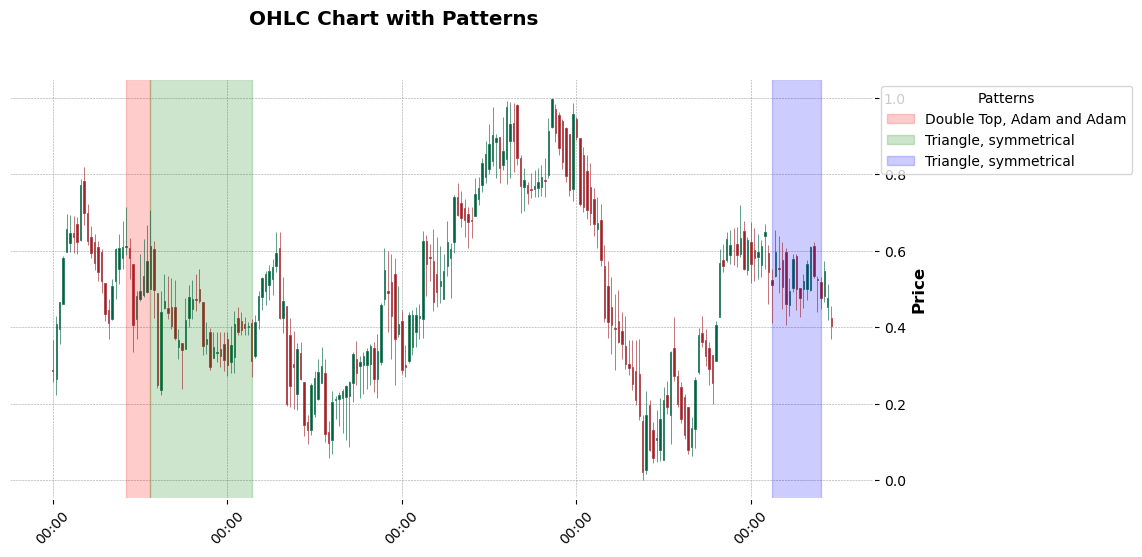

[[1.0, 1.0143786668777466, 0.9507311582565308, 0.061158254742622375], [1.0, 1.001285195350647, 0.1917765885591507, 0.12884081900119781], [0.0, 0.9742864370346069, 0.11122447997331619, 0.03328729420900345]]
 predicted patterns


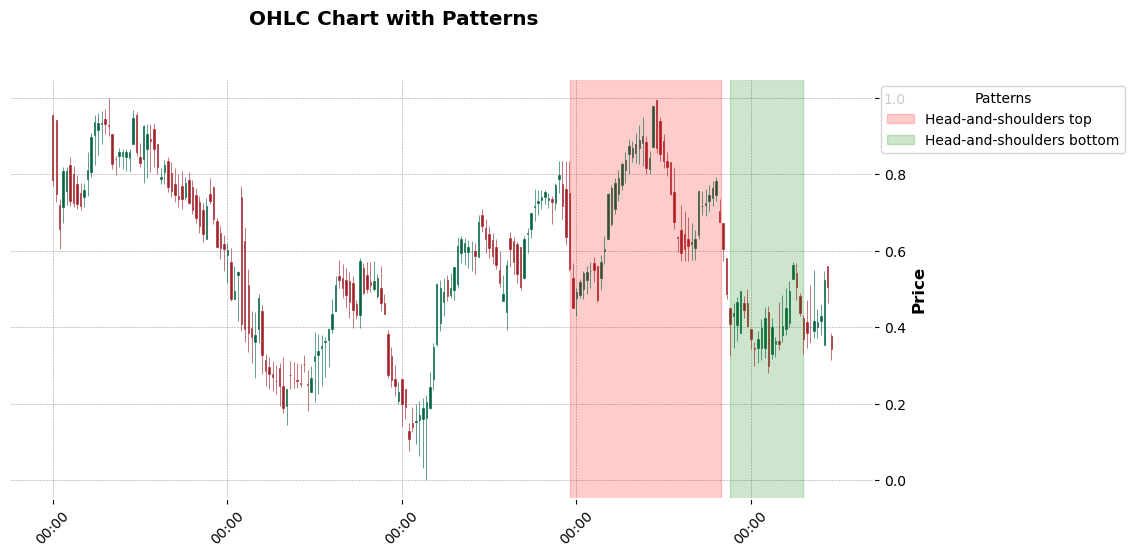

[[3.0, 1.0159519910812378, 0.7578154802322388, 0.19323092699050903], [5.0, 0.966005802154541, 0.9128000140190125, 0.0938134714961052]]
Real Patterns


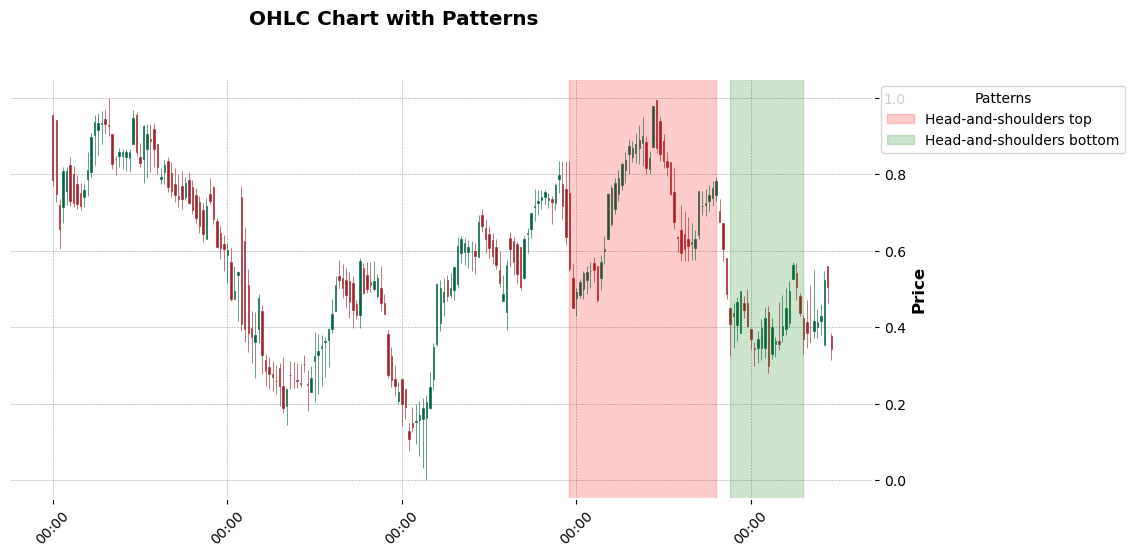

[[3.0, 1.0159519910812378, 0.7578154802322388, 0.19323092699050903], [5.0, 0.966005802154541, 0.9128000140190125, 0.0938134714961052]]
 predicted patterns


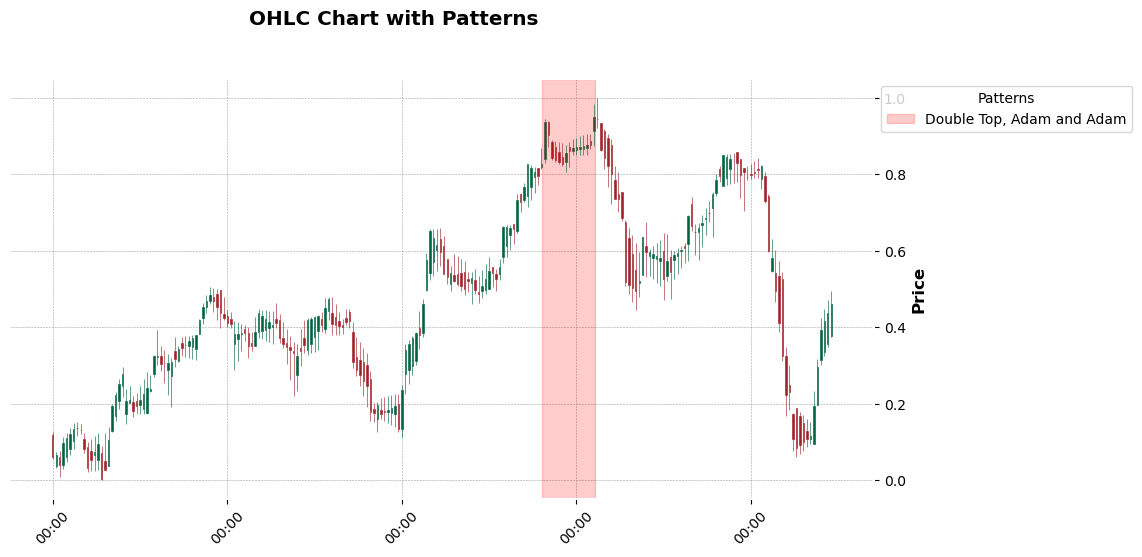

[[0.0, 0.9564594030380249, 0.6596150398254395, 0.06701746582984924]]
Real Patterns


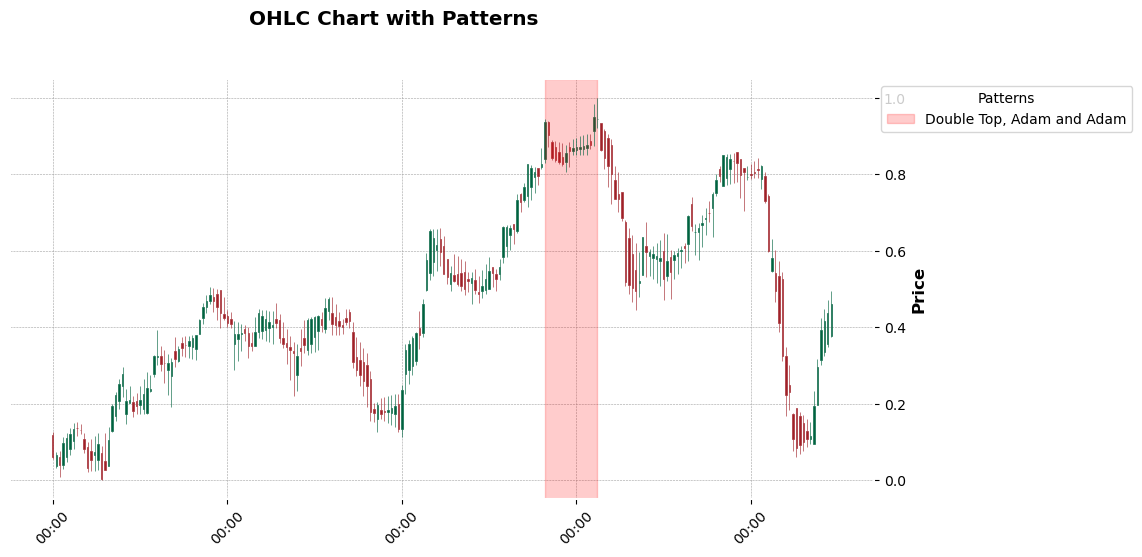

[[0.0, 0.9564594030380249, 0.6596150398254395, 0.06701746582984924]]
 predicted patterns


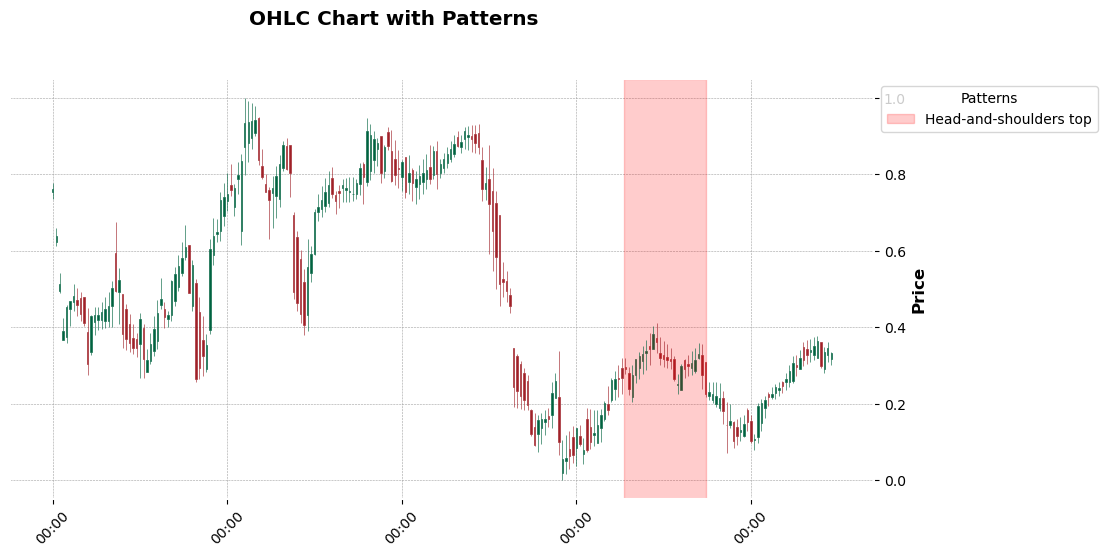

[[3.0, 1.0075411796569824, 0.7828229665756226, 0.10528445988893509]]
Real Patterns


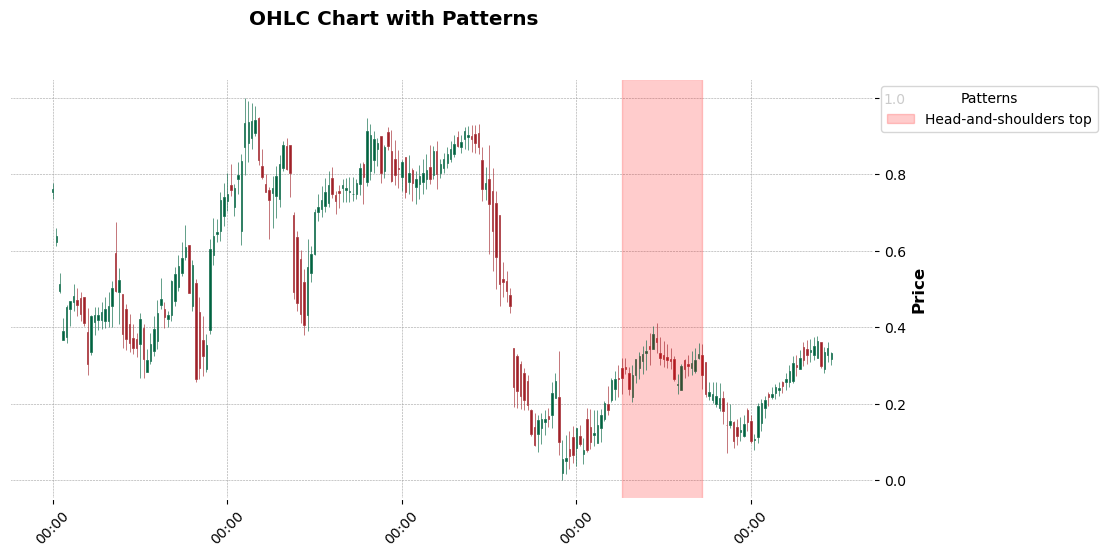

[[3.0, 1.0075411796569824, 0.7828229665756226, 0.10528445988893509]]
 predicted patterns


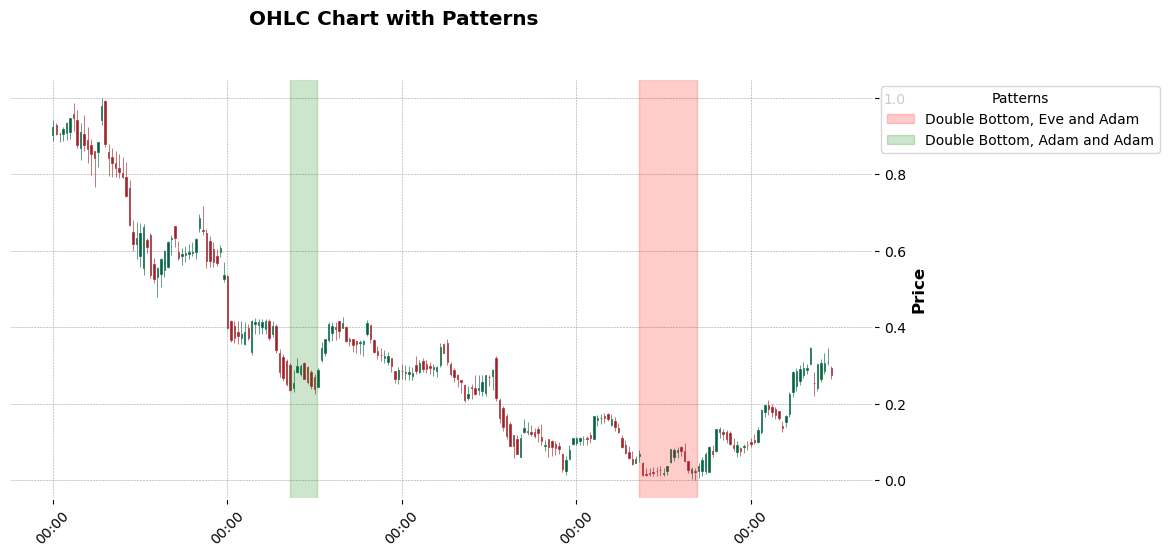

[[2.0, 1.0276634693145752, 0.7864757776260376, 0.07462584227323532], [4.0, 1.0201332569122314, 0.3209056258201599, 0.03484460711479187]]
Real Patterns


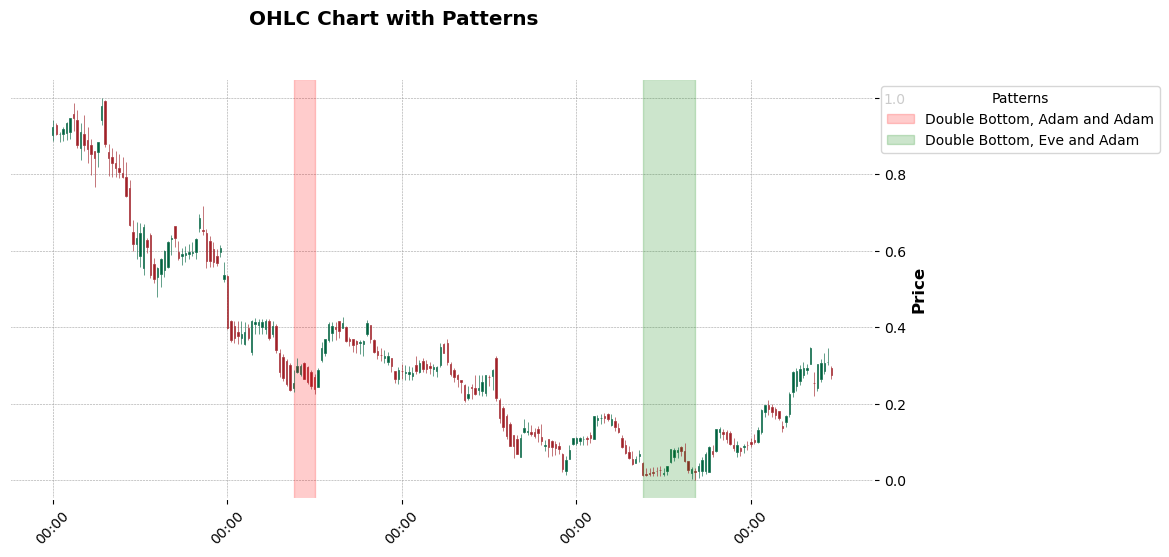

[[2.0, 1.0276634693145752, 0.7864757776260376, 0.07462584227323532], [4.0, 1.0201332569122314, 0.3209056258201599, 0.03484460711479187]]
 predicted patterns


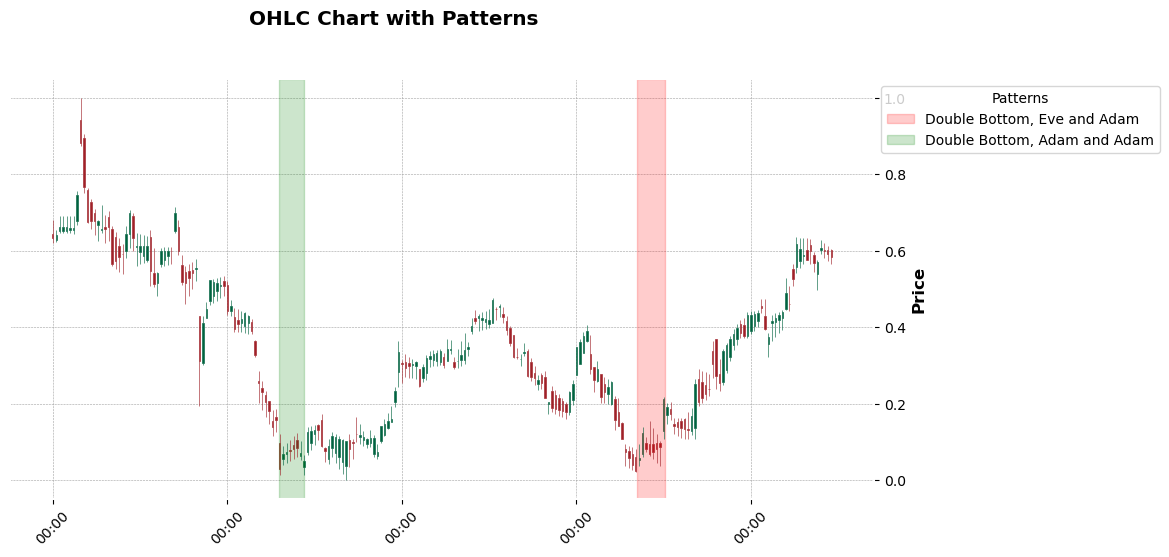

[[2.0, 1.0203438997268677, 0.7645227313041687, 0.035605065524578094], [4.0, 1.0025423765182495, 0.30499112606048584, 0.032532401382923126]]
Real Patterns


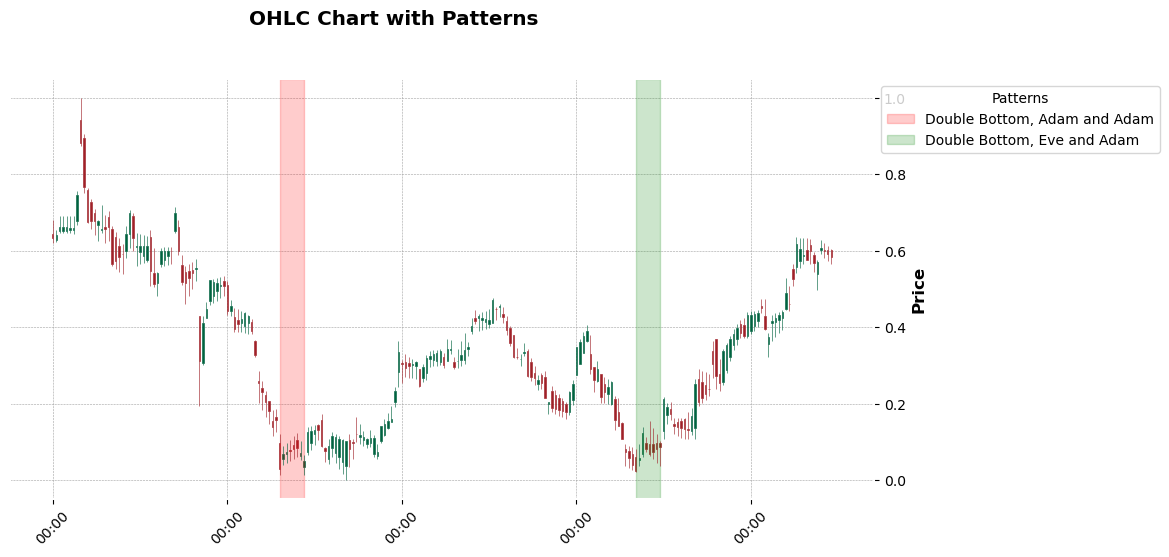

[[2.0, 1.0203438997268677, 0.7645227313041687, 0.035605065524578094], [4.0, 1.0025423765182495, 0.30499112606048584, 0.032532401382923126]]
 predicted patterns


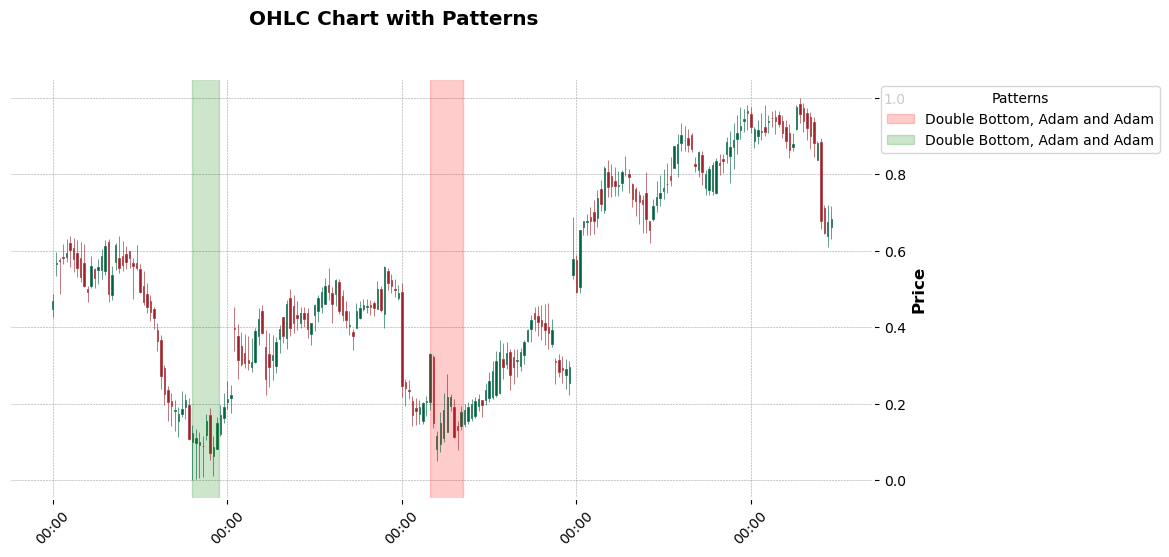

[[4.0, 1.0189626216888428, 0.5030534267425537, 0.042347922921180725], [4.0, 1.0148701667785645, 0.1950569599866867, 0.035053759813308716]]
Real Patterns


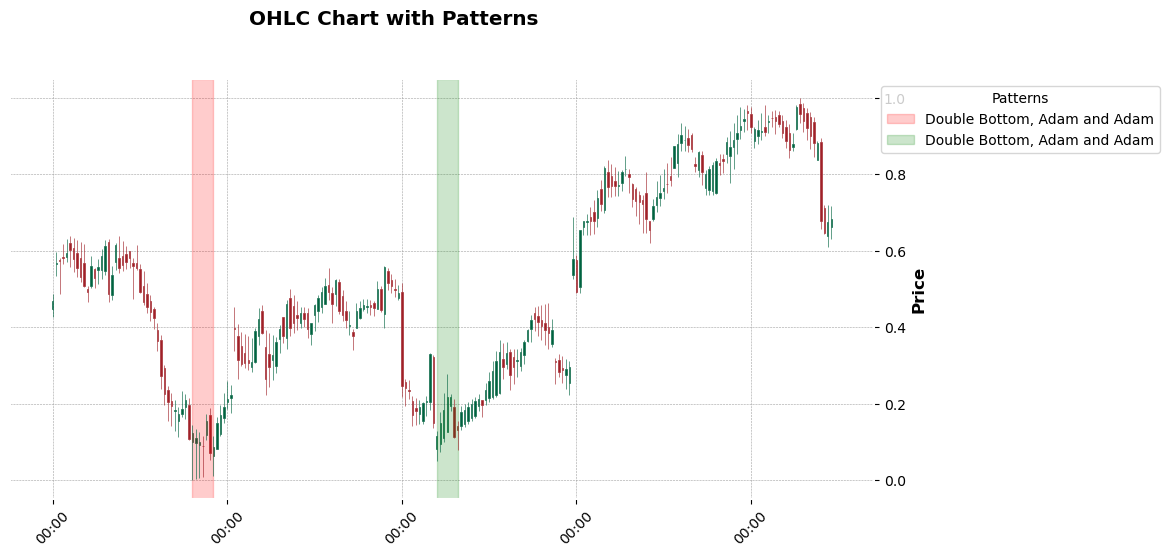

[[4.0, 1.0189626216888428, 0.5030534267425537, 0.042347922921180725], [4.0, 1.0148701667785645, 0.1950569599866867, 0.035053759813308716]]
 predicted patterns


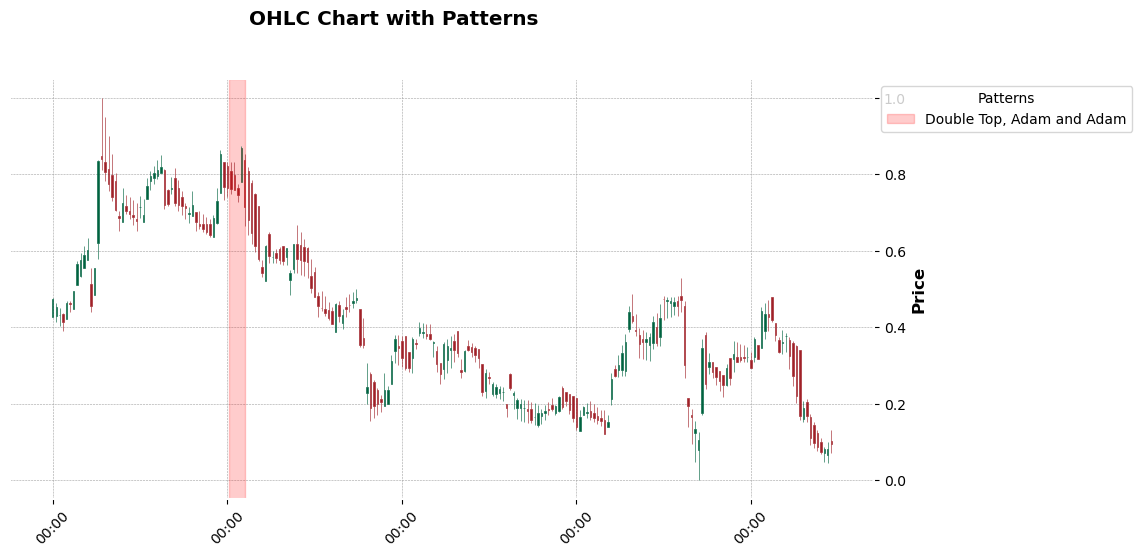

[[0.0, 1.038604974746704, 0.23530177772045135, 0.02069547027349472]]
Real Patterns


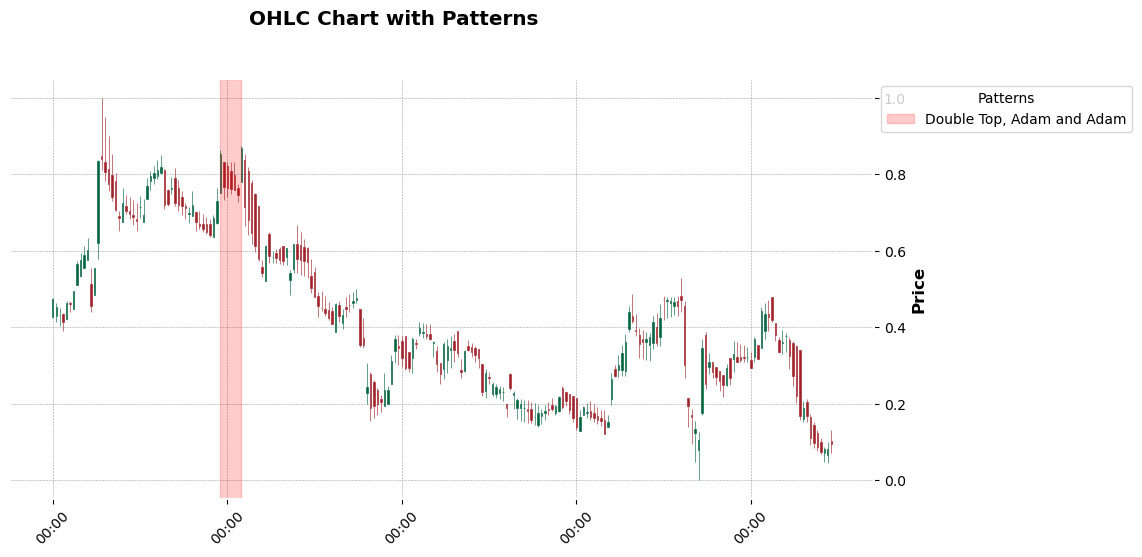

[[0.0, 1.038604974746704, 0.23530177772045135, 0.02069547027349472]]
 predicted patterns


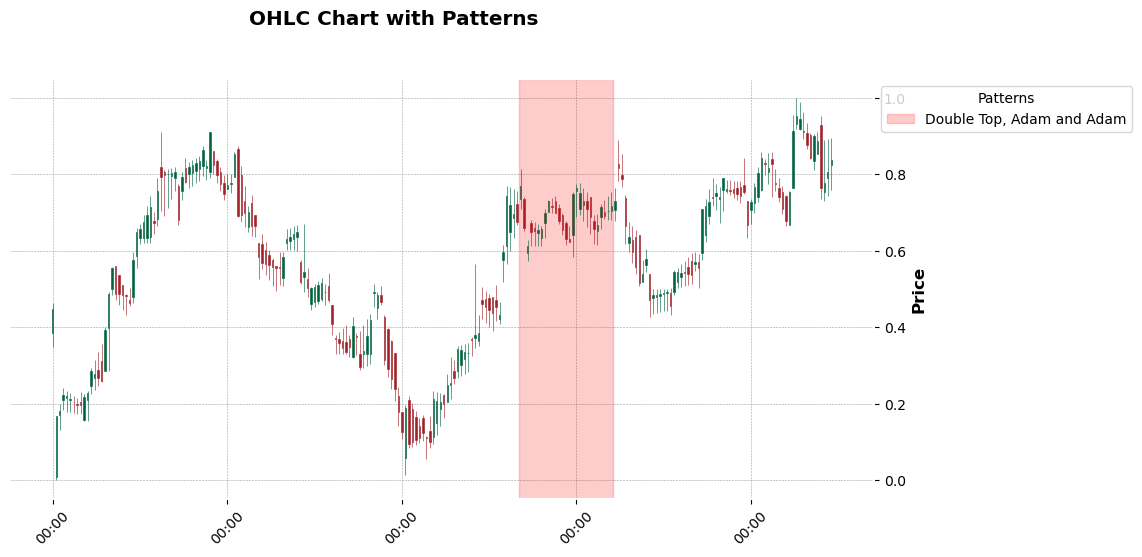

[[0.0, 1.0096079111099243, 0.6567079424858093, 0.11967293173074722]]
Real Patterns


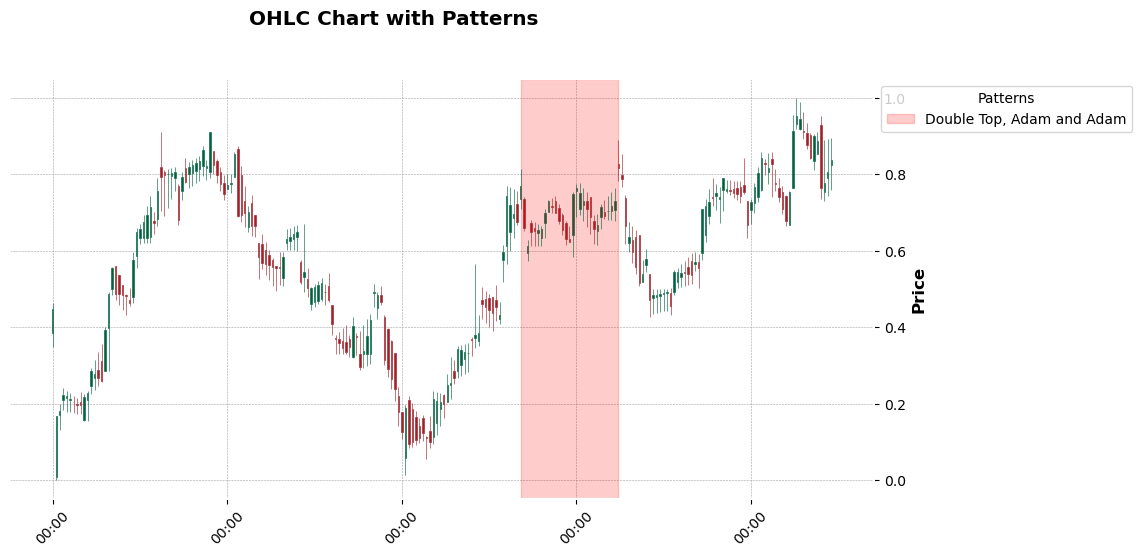

[[0.0, 1.0096079111099243, 0.6567079424858093, 0.11967293173074722]]


In [ ]:
x= data[0] # get the ohcl data
lable = data[1]
x = x.to(DEVICE)
lable = lable.to(DEVICE)
for idx in range(10):
    bboxes = cellboxes_to_boxes(model(x))
    bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
    # plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)
    print(" predicted patterns")
    plot_image(x[idx], bboxes)
    print(bboxes)
    
    
    lable_bboxes = cellboxes_to_boxes(lable)
    lable_bboxes = non_max_suppression(lable_bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
    print ("Real Patterns")
    plot_image(x[idx], lable_bboxes)
    print(bboxes)

# import sys
# sys.exit()

In [ ]:
test_data = next(iter(test_loader))

 predicted patterns


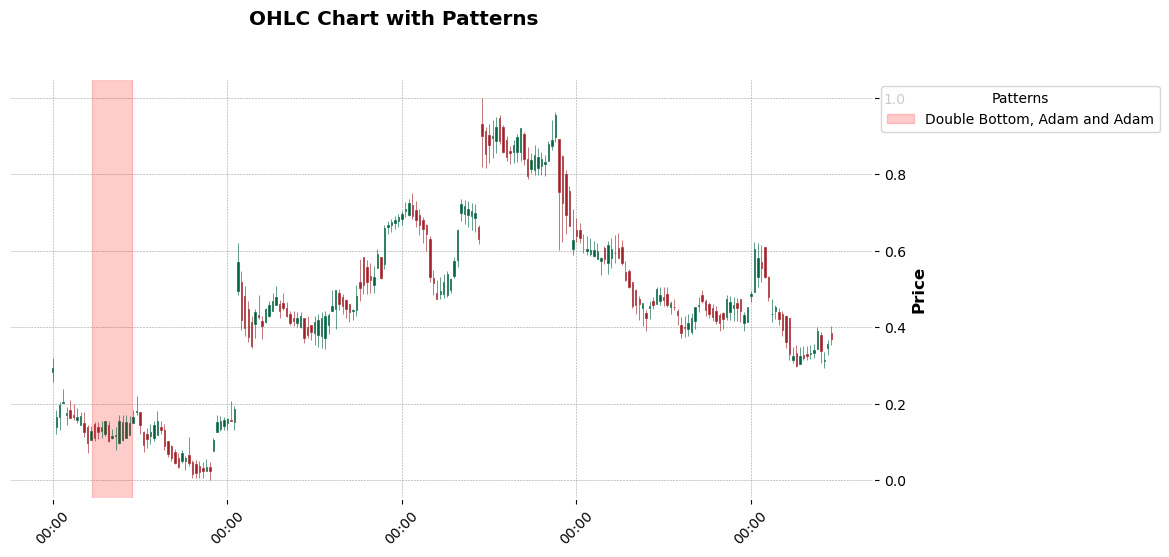

[[4.0, 0.4146020710468292, 0.07590319961309433, 0.05133221670985222]]
Real Patterns


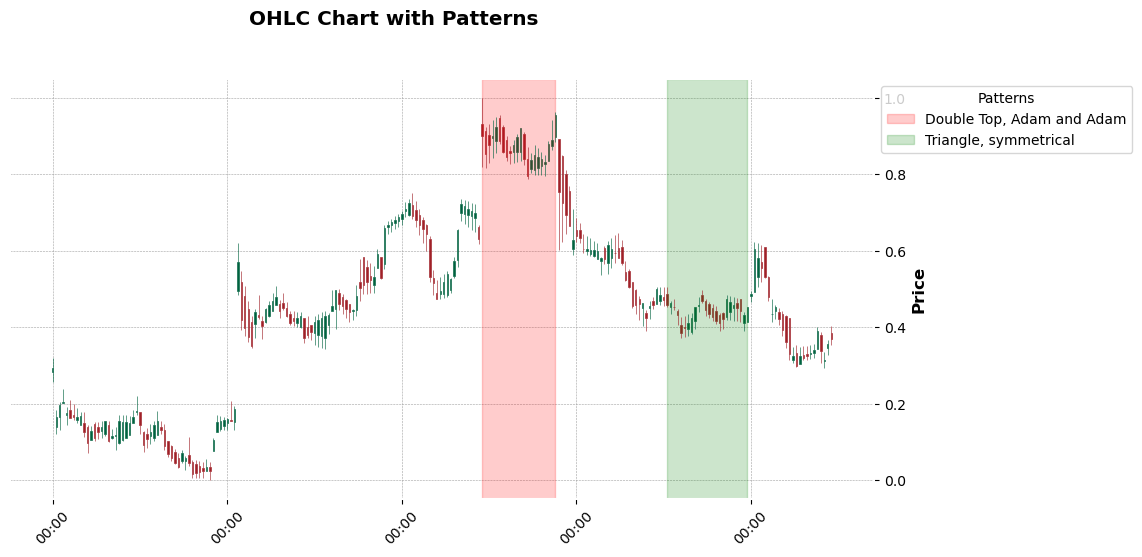

[[4.0, 0.4146020710468292, 0.07590319961309433, 0.05133221670985222]]
 predicted patterns


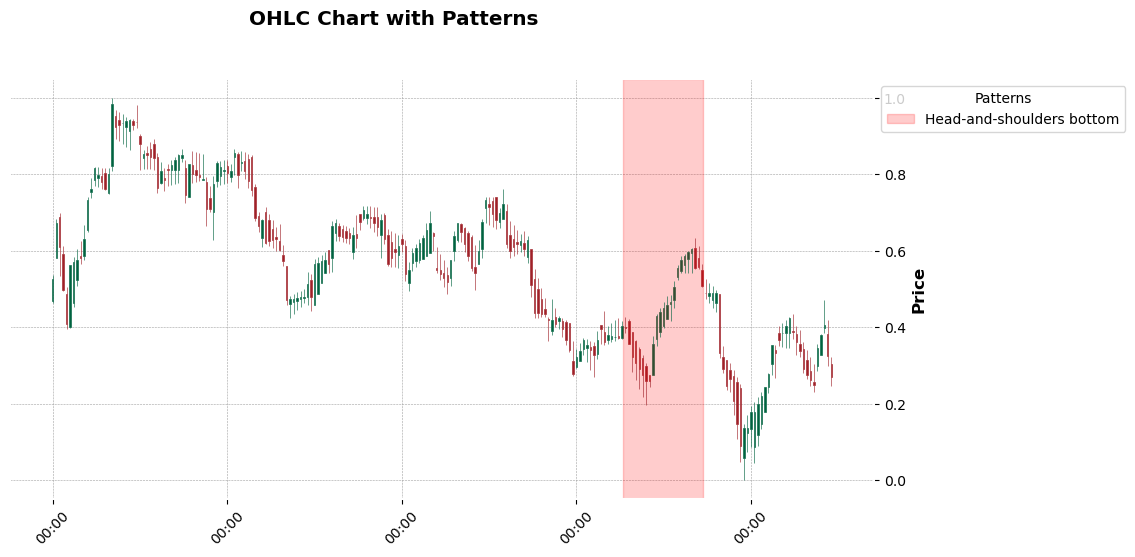

[[5.0, 0.7221264243125916, 0.7806493043899536, 0.10274053364992142]]
Real Patterns


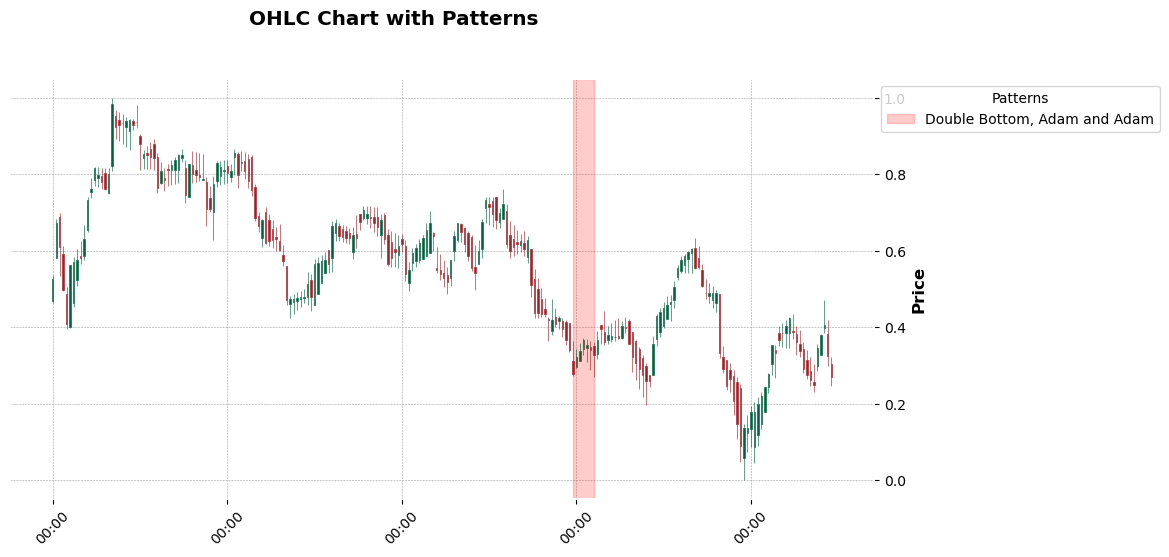

[[5.0, 0.7221264243125916, 0.7806493043899536, 0.10274053364992142]]
 predicted patterns


C:\Users\gwiku\AppData\Local\Temp\ipykernel_18268\3204263493.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Patterns")


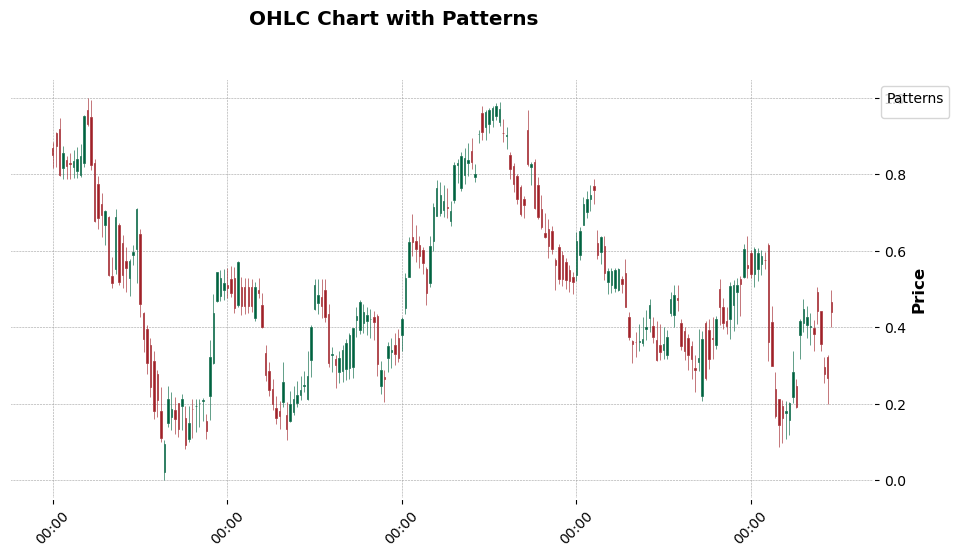

[]
Real Patterns


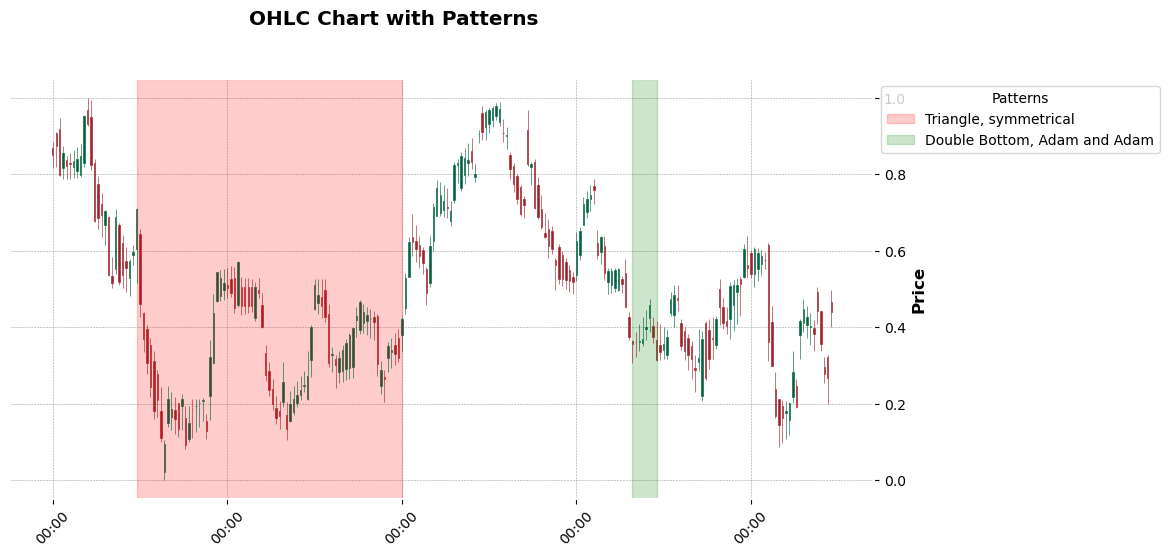

[]
 predicted patterns


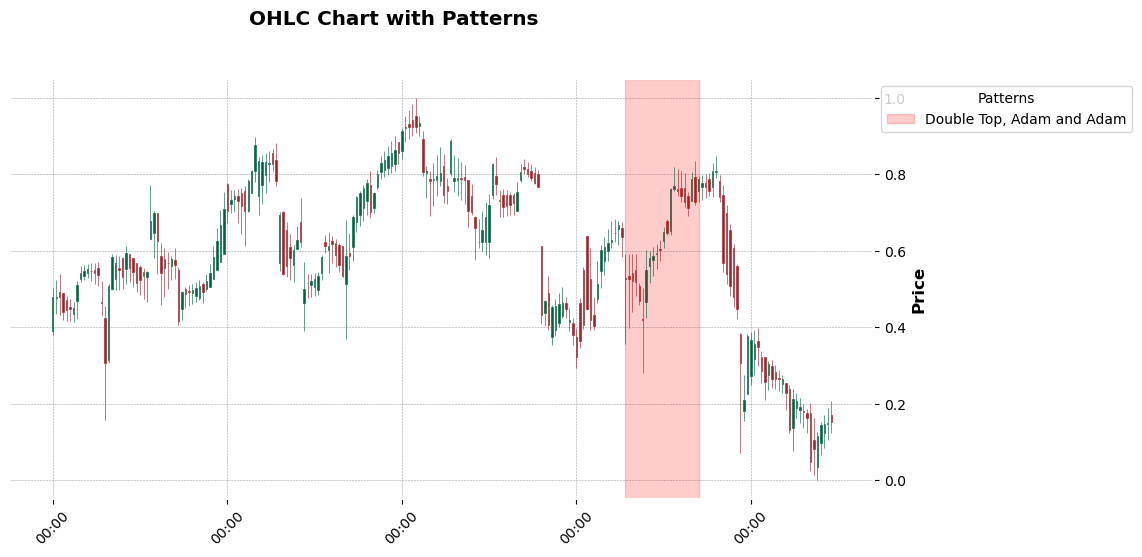

[[0.0, 0.44928523898124695, 0.7790490984916687, 0.09377112239599228]]
Real Patterns


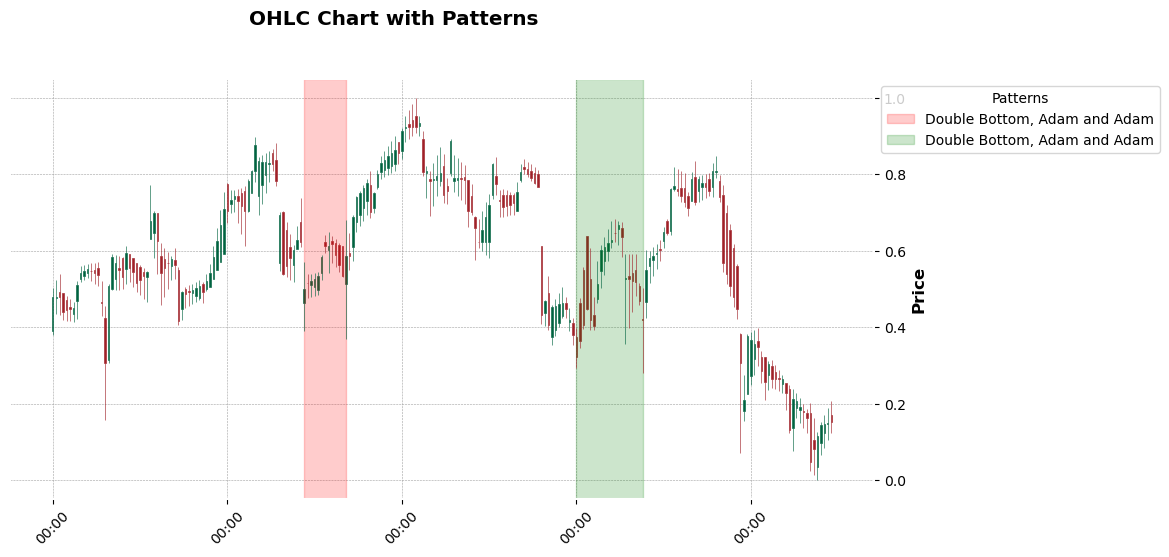

[[0.0, 0.44928523898124695, 0.7790490984916687, 0.09377112239599228]]
 predicted patterns


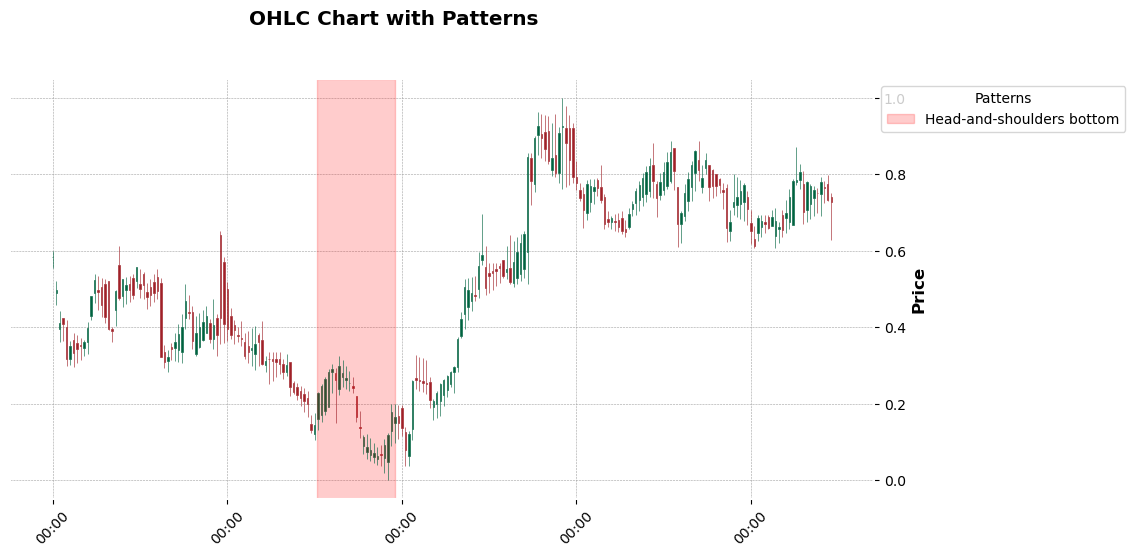

[[5.0, 0.4856409728527069, 0.3875584304332733, 0.09936699271202087]]
Real Patterns


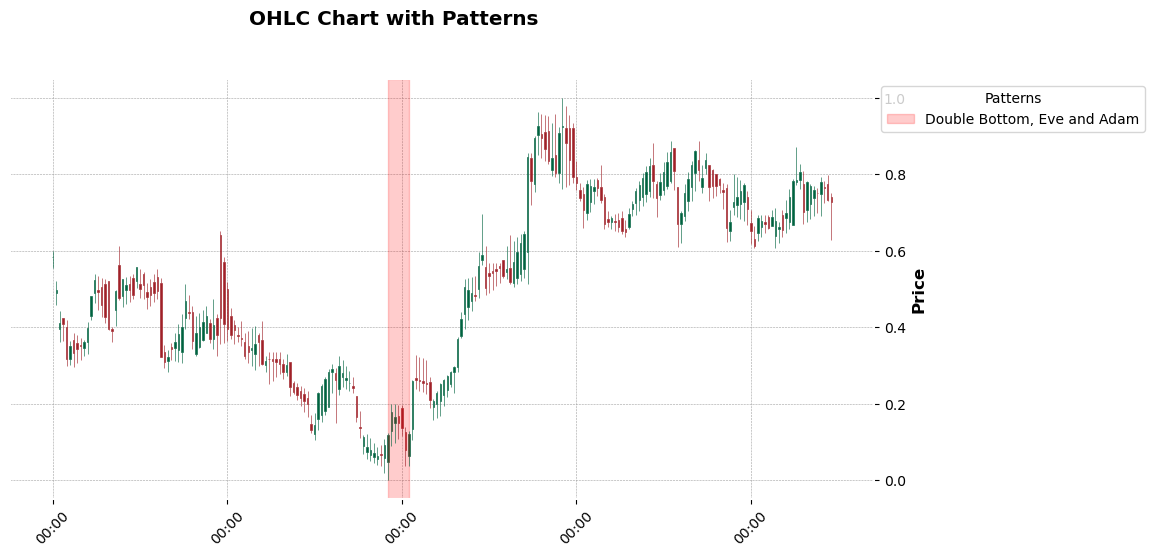

[[5.0, 0.4856409728527069, 0.3875584304332733, 0.09936699271202087]]
 predicted patterns


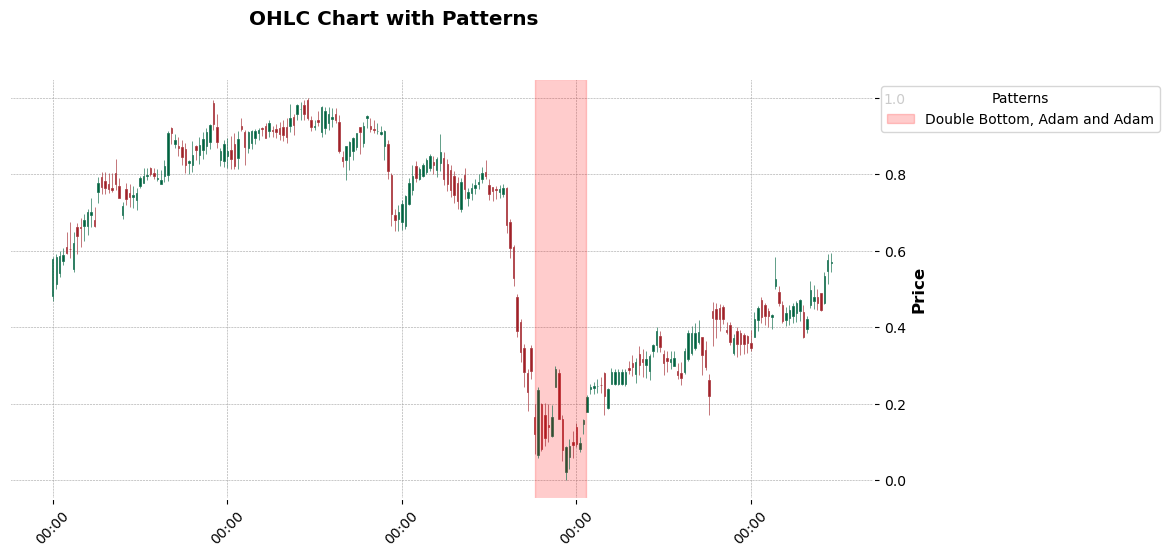

[[4.0, 0.4611903429031372, 0.6494101285934448, 0.06558811664581299]]
Real Patterns


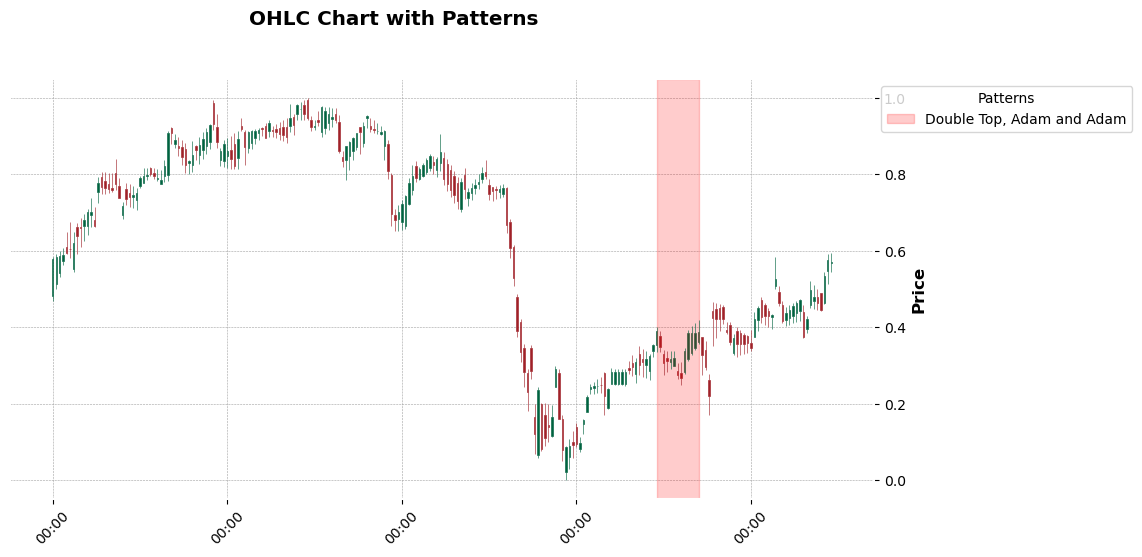

[[4.0, 0.4611903429031372, 0.6494101285934448, 0.06558811664581299]]
 predicted patterns


C:\Users\gwiku\AppData\Local\Temp\ipykernel_18268\3204263493.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Patterns")


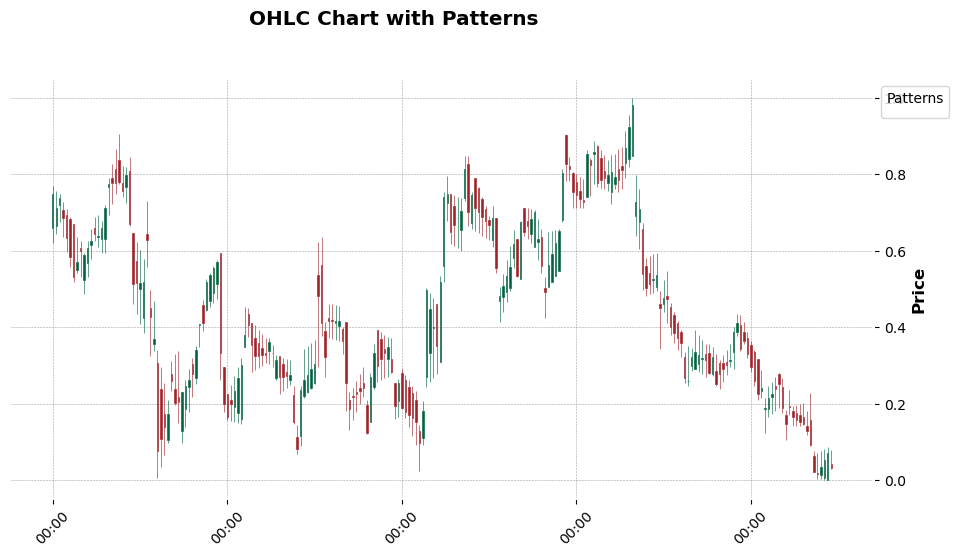

[]
Real Patterns


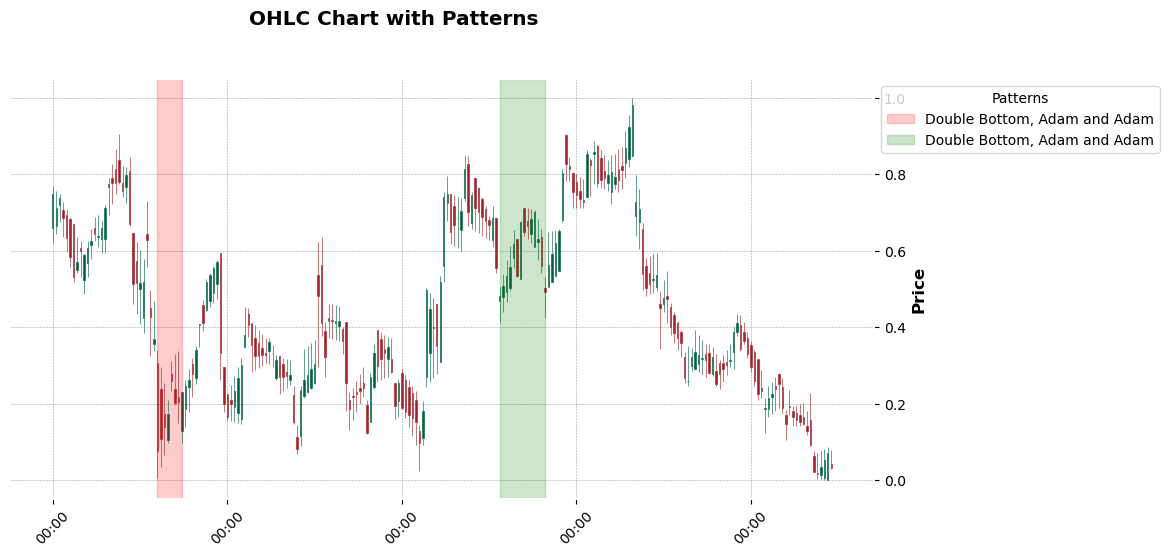

[]
 predicted patterns


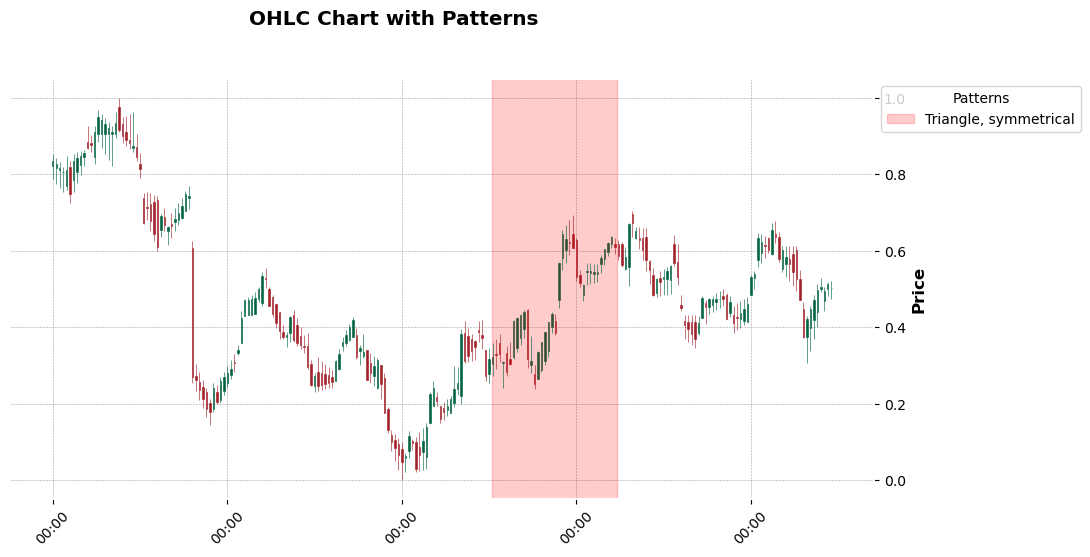

[[1.0, 0.47481685876846313, 0.6411581039428711, 0.15961652994155884]]
Real Patterns


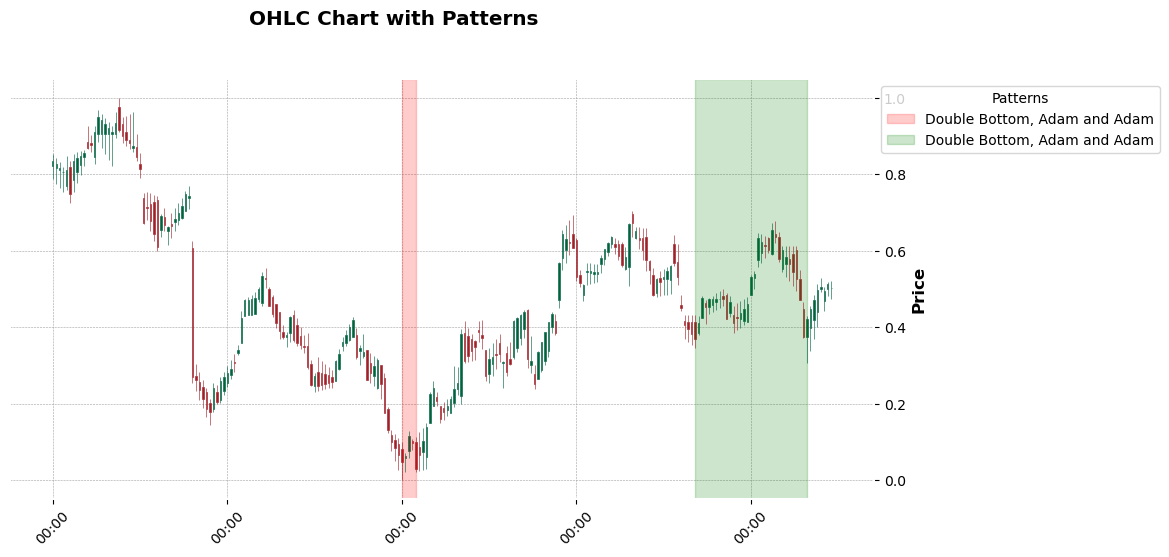

[[1.0, 0.47481685876846313, 0.6411581039428711, 0.15961652994155884]]
 predicted patterns


C:\Users\gwiku\AppData\Local\Temp\ipykernel_18268\3204263493.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Patterns")


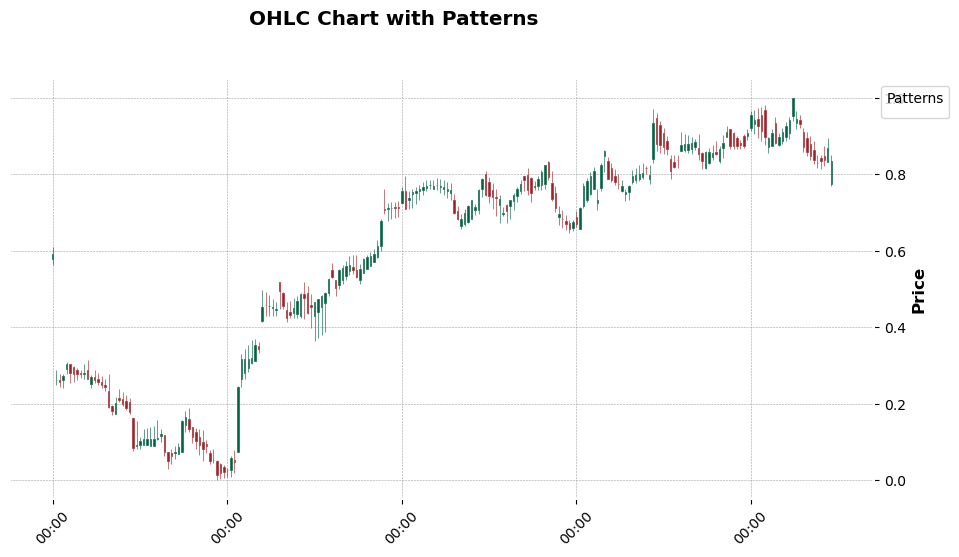

[]
Real Patterns


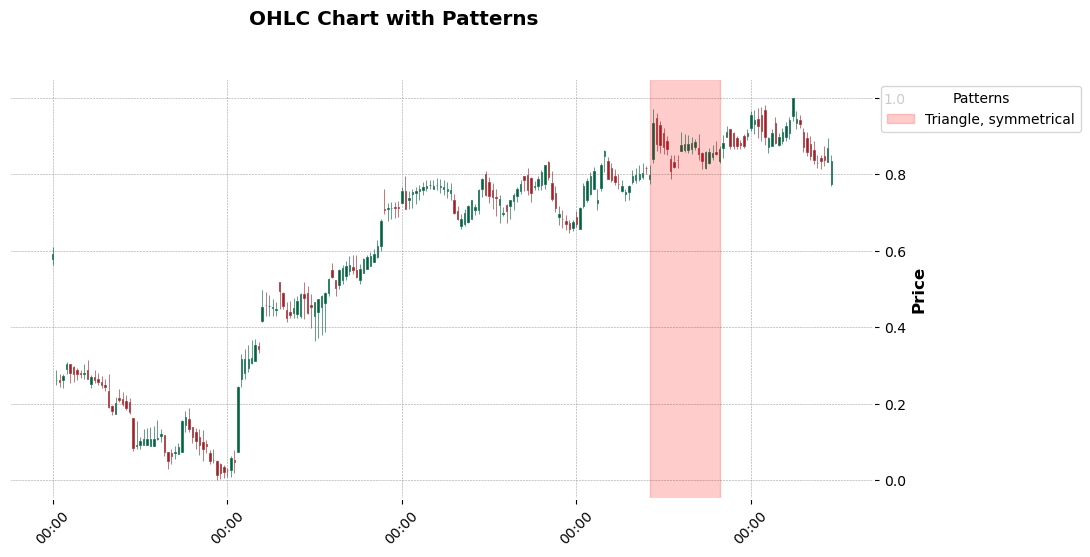

[]
 predicted patterns


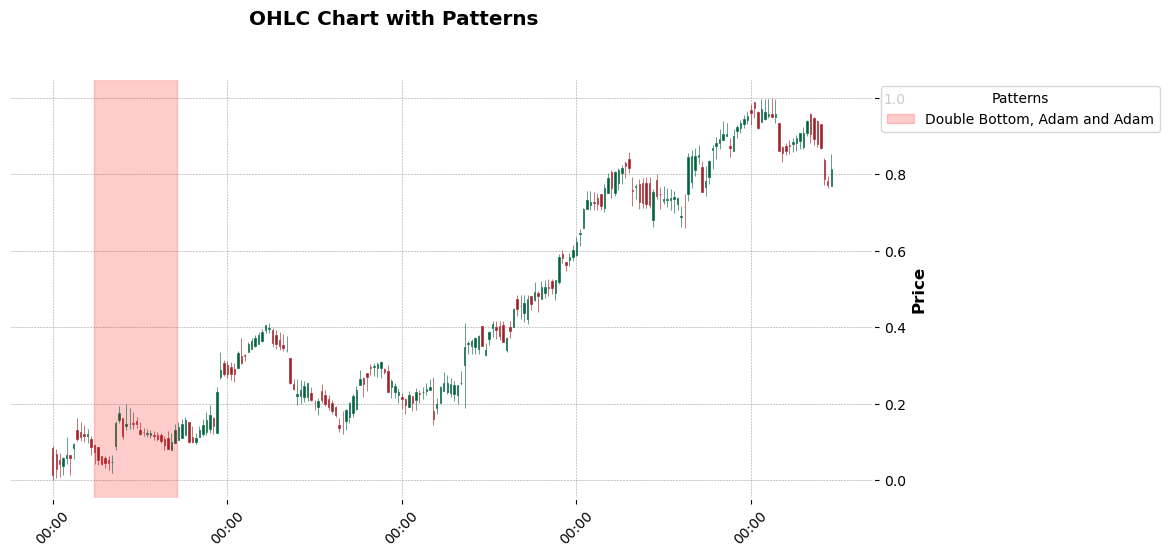

[[4.0, 0.40602558851242065, 0.10583486407995224, 0.10489562898874283]]
Real Patterns


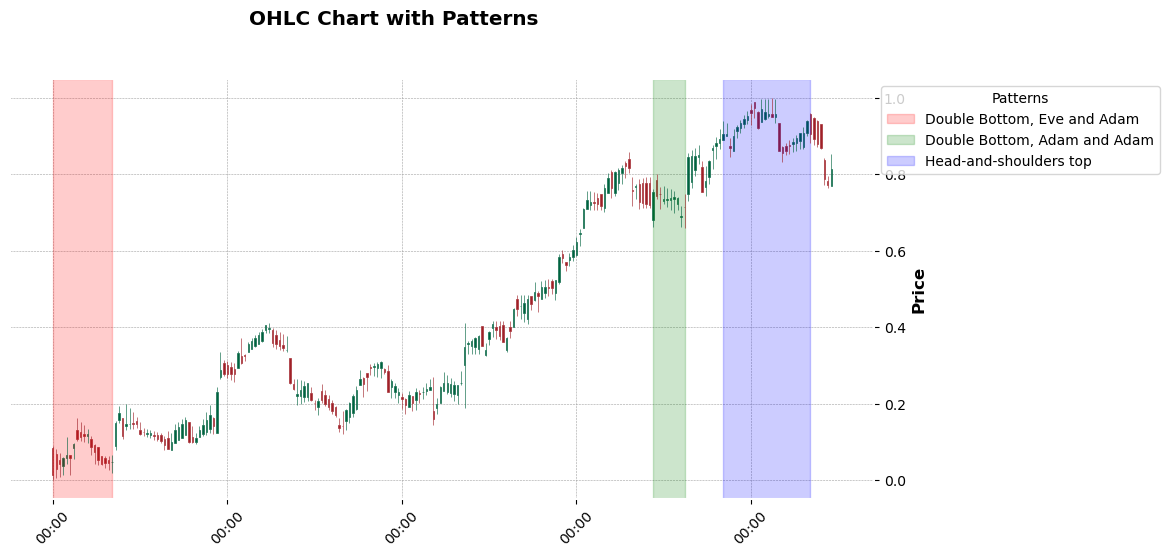

[[4.0, 0.40602558851242065, 0.10583486407995224, 0.10489562898874283]]


In [ ]:
x= test_data[0] # get the ohcl data
lable = test_data[1]
x = x.to(DEVICE)
lable = lable.to(DEVICE)
for idx in range(10):
    bboxes = cellboxes_to_boxes(model(x))
    bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
    # plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)
    print(" predicted patterns")
    plot_image(x[idx], bboxes)
    print(bboxes)
    
    
    lable_bboxes = cellboxes_to_boxes(lable)
    lable_bboxes = non_max_suppression(lable_bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
    print ("Real Patterns")
    plot_image(x[idx], lable_bboxes)
    print(bboxes)

# import sys
# sys.exit()

In [ ]:
x

tensor([[[0.2833, 0.1378, 0.1655,  ..., 0.3104, 0.3464, 0.3838],
         [0.3195, 0.1842, 0.2041,  ..., 0.3348, 0.3664, 0.4023],
         [0.2569, 0.1204, 0.1314,  ..., 0.2943, 0.3284, 0.3531],
         [0.2919, 0.1642, 0.1964,  ..., 0.3129, 0.3548, 0.3693]],

        [[0.4674, 0.5804, 0.6888,  ..., 0.3967, 0.3827, 0.3040],
         [0.5362, 0.6824, 0.7003,  ..., 0.4707, 0.4196, 0.3229],
         [0.4645, 0.5804, 0.5344,  ..., 0.3852, 0.2985, 0.2447],
         [0.5265, 0.6735, 0.6097,  ..., 0.4069, 0.3253, 0.2694]],

        [[0.8687, 0.9085, 0.9184,  ..., 0.2957, 0.3210, 0.4659],
         [0.8841, 0.9102, 0.9485,  ..., 0.3211, 0.3272, 0.4966],
         [0.8180, 0.8194, 0.7961,  ..., 0.2527, 0.1999, 0.4002],
         [0.8512, 0.8756, 0.7990,  ..., 0.2779, 0.2661, 0.4393]],

        ...,

        [[0.4230, 0.1611, 0.1429,  ..., 0.7467, 0.7914, 0.5095],
         [0.4401, 0.1702, 0.1611,  ..., 0.8686, 0.9096, 0.6134],
         [0.4024, 0.1429, 0.1246,  ..., 0.7444, 0.7914, 0.5095],
     

In [ ]:
bboxes = cellboxes_to_boxes(model(x))
bboxes[1]

[[0.0, 0.15014925599098206, 0.0825686976313591, 0.0700874999165535],
 [0.0, 0.11709905415773392, 0.22317738831043243, 0.11324156075716019],
 [1.0, 0.13485832512378693, 0.3326228857040405, 0.07411070913076401],
 [3.0, 0.256134569644928, 0.4945438802242279, 0.08668280392885208],
 [4.0, 0.2248508334159851, 0.6638943552970886, 0.10344868153333664],
 [5.0, 0.7221264243125916, 0.7806493043899536, 0.10274053364992142],
 [4.0, 0.26364630460739136, 0.9064221978187561, 0.08031850308179855]]

In [ ]:
for box in bboxes[1]:
    print(box)

[0.0, 0.15014925599098206, 0.0825686976313591, 0.0700874999165535]
[0.0, 0.11709905415773392, 0.22317738831043243, 0.11324156075716019]
[1.0, 0.13485832512378693, 0.3326228857040405, 0.07411070913076401]
[3.0, 0.256134569644928, 0.4945438802242279, 0.08668280392885208]
[4.0, 0.2248508334159851, 0.6638943552970886, 0.10344868153333664]
[5.0, 0.7221264243125916, 0.7806493043899536, 0.10274053364992142]
[4.0, 0.26364630460739136, 0.9064221978187561, 0.08031850308179855]


In [ ]:
x[1].shape

torch.Size([4, 224])

In [ ]:
import torch
import pandas as pd



# Transpose the tensor to make it [224, 4] and move to CPU
tensor_transposed = x[1].T.cpu()

# Convert to a pandas DataFrame
df = pd.DataFrame(tensor_transposed.numpy(), columns=['Open', 'High', 'Low', 'Close'])

df


Open      High       Low     Close
0    0.467431  0.536177  0.464477  0.526543
1    0.580357  0.682398  0.580357  0.673469
2    0.688776  0.700255  0.534439  0.609694
3    0.591837  0.613521  0.494898  0.496173
4    0.487245  0.505102  0.395408  0.409439
..        ...       ...       ...       ...
219  0.298469  0.355867  0.285715  0.345663
220  0.326531  0.381378  0.326531  0.380102
221  0.396684  0.470663  0.385204  0.406888
222  0.382653  0.419643  0.298469  0.325255
223  0.303961  0.322946  0.244729  0.269386

[224 rows x 4 columns]

In [ ]:
#  change the dataset.py or whatever to matc teh prediction structure which is relative to the 1/7 section